# XGBOOST MODEL 

Welcome! This notebook is the result of a full month of work on the project. It presents and explains all the ideas, tests, and methods we used. You will find comments (marked with #) on certain parts of the script that are either too long to execute or were not selected for the most efficient script. 

Small precision, due to a lack of rigor, we loose the best script (hyperparameter who allows us to find the best weights), so this notebook will not create the best submission possible, 

We apologies for this small incident.

## How to Use This Notebook

We have used uv for the project and the environment's management, but you can work with pip as well.

To execute the script, run the cells from top to bottom. 


In [1]:
### Install uv
# powershell -ExecutionPolicy ByPass -c "irm https://astral.sh/uv/install.ps1 | iex"
# set Path=C:\Users\Name_User\.local\bin;%Path%
# uv self version


# uv init C:\Users\Name_User\Documents\centraleSupelec\3A\cours\ML\KAGGLE
# uv add numpy pandas matplotlib seaborn scipy scikit-learn imbalanced-learn xgboost joblib yasa mne numba optuna plotly pywavelets

### If you use pip, you will find a recquirements.txt who contain every libs we use.
# pip install -r Path/requirements.txt

On ajoute ici toutes les librairies qui seront utilisées par la suite. on peut aussi faire le choix de les importer lors de la première utilisation mais cela permet de synthétiser le script.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


from scipy.stats import iqr
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from pathlib import Path
from scipy.signal import butter, filtfilt, welch, spectrogram
from scipy.stats import entropy, skew, kurtosis, uniform, randint
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV, GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import joblib
import os
import warnings


In [3]:
sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


## Step 1 — Configure Paths and Hyperparameters

Choose where your data lives and where to store the outputs. Update the paths (or export `CS2025_DATA_ROOT`) if your layout differs from the default project structure.


In [ ]:
# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"MonChemin\ML\Kaggle_final") 

#Model dir
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True, parents=True) 
MODEL_OUT = MODEL_DIR / 'xgb_rendu_model.joblib'

# Cache to stock dataset
CACHE_DIR = BUNDLE_DIR / 'cache'
CACHE_DIR.mkdir(exist_ok=True)
DATASET_CACHE_FILE = CACHE_DIR / 'Dataset_features.parquet'

# Frequency range for theoretical sleep waves, we will add explainations later
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 16),
    'beta': (16, 30)
}

# Definition of some values
RANDOM_STATE = 42
VALID_LABELS = [0, 1, 2, 3, 4]
fs = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = fs * EPOCH_DURATION_SECONDS

SUB_EPOCH_DURATION_SECONDS = 5
SAMPLES_PER_SUB_EPOCH = fs * SUB_EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final


## Step 2 — Data Access Helpers


In [5]:
from typing import Iterator, List, Tuple

SAMPLES_PER_CHANNEL = fs * EPOCH_DURATION_SECONDS

###### Analyse de bandes passantes

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(signal, fs, lowcut=0.5, highcut=30.0, order=4):
    """
    signal: np.array shape (n_channels, n_samples)
    renvoie le signal filtré (même shape)
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.empty_like(signal)
    for ch in range(signal.shape[0]):
        # filtfilt pour éviter le décalage de phase
        filtered[ch] = filtfilt(b, a, signal[ch])
    return filtered


def _discover_record_ids(base_dir: Path, split: str) -> List[int]:
    """Return the ordered list of record IDs for a split."""
    manifest_path = base_dir / 'records_manifest.csv'
    if manifest_path.exists():
        manifest = pd.read_csv(manifest_path)
        subset = manifest[manifest['split'] == split]
        return subset['record_id'].astype(int).tolist()

    signal_dir = base_dir / f'signals_{split}'
    record_ids: List[int] = []
    for path in sorted(signal_dir.glob('signal_*.npy')):
        try:
            record_ids.append(int(path.stem.split('_')[-1]))
        except ValueError as exc:
            raise ValueError(f'Unexpected signal filename: {path.name}') from exc
    return record_ids


def _load_signal_array(path: Path) -> np.ndarray:
    """Load and validate a signal array shaped (NUM_CHANNELS, samples)."""
    array = np.load(path).astype(np.float32)
    if array.ndim != 2 or array.shape[0] != NUM_CHANNELS:
        raise ValueError(f'Signal array at {path} has shape {array.shape}, expected ({NUM_CHANNELS}, N_samples).')
    if array.shape[1] % SAMPLES_PER_CHANNEL != 0:
        raise ValueError(
            f'Signal array at {path} has {array.shape[1]} samples, not divisible by {SAMPLES_PER_CHANNEL}.'
        )
    return array


def _load_target_array(path: Path) -> np.ndarray:
    """Load the per-epoch labels (1D, int16)."""
    array = np.load(path).astype(np.int16)
    if array.ndim == 2 and array.shape[0] == NUM_CHANNELS:
        array = array[0]
    if array.ndim != 1:
        raise ValueError(f'Target array at {path} must be 1D, found shape {array.shape}.')
    return array


def iter_signals_and_targets(base_dir: Path, split: str) -> Iterator[Tuple[int, np.ndarray, np.ndarray]]:
    """Yield (record_id, signal_array, target_array) tuples for the chosen split."""
    record_ids = _discover_record_ids(base_dir, split)
    if not record_ids:
        raise FileNotFoundError(f'No records found for split={split} under {base_dir}.')

    signal_dir = base_dir / f'signals_{split}'
    target_dir = base_dir / f'targets_{split}'

    for record_id in record_ids:
        signal_path = signal_dir / f'signal_{record_id}.npy'
        target_path = target_dir / f'target_{record_id}.npy'
        if not signal_path.exists() or not target_path.exists():
            raise FileNotFoundError(f'Missing signal/target pair for record {record_id} in split {split}.')
        signal_array = _load_signal_array(signal_path)
        target_array = _load_target_array(target_path)
        yield record_id, signal_array, target_array

def iter_signals_only(base_dir: Path, split: str) -> Iterator[Tuple[int, np.ndarray]]:
    """Yield (record_id, signal_array) tuples without requiring targets."""
    record_ids = _discover_record_ids(base_dir, split)
    if not record_ids:
        raise FileNotFoundError(f'No records found for split={split} under {base_dir}.')

    signal_dir = base_dir / f'signals_{split}'

    for record_id in record_ids:
        signal_path = signal_dir / f'signal_{record_id}.npy'
        if not signal_path.exists():
            raise FileNotFoundError(f'Missing signal for record {record_id} in split {split}.')
        signal_array = _load_signal_array(signal_path)
        yield record_id, signal_array


### Sleep Stage Labels and Colours

The mapping below helps keep plots readable. Feel free to customise the colour palette or add channel names that match your sensor configuration.


In [6]:
STAGE_LABELS = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM', -1: 'Unknown'}
STAGE_COLORS = {
    0: '#d4b483',  # Wake
    1: '#f7a399',  # N1
    2: '#7fcdbb',  # N2
    3: '#41b6c4',  # N3
    4: '#c51b8a',  # REM
    -1: '#9e9e9e',
}
CHANNEL_NAMES = {idx: f'Channel {idx}' for idx in range(NUM_CHANNELS)}


## Step 3.A — Feature Engineering Helpers provided by research

Each 30-second epoch is summarised by four amplitude-based statistics per channel: standard deviation, minimum, maximum, and peak-to-peak range. These helpers match the functions in the CLI script.


In [7]:
import math
from collections import Counter

import numpy as np
import pandas as pd
import pywt  # pip install PyWavelets
import yasa

from scipy.signal import welch, hilbert, butter, filtfilt, coherence
from scipy.signal.windows import dpss
from scipy.stats import iqr, kurtosis, skew, linregress, entropy
from scipy.stats.mstats import gmean

# ==========================================
# 1. FILTERING HELPERS
# ==========================================

import numpy as np
import pandas as pd

def drop_correlated_features(df, threshold=0.98):
    """
    Removes columns that are highly correlated with each other (above the threshold).
    
    Why do this? (The "Why")
    - Multicollinearity: If two features are 99% identical, the model gets confused about 
      which one is actually important. It splits the "credit" between them.
    - Performance: Removing redundant features speeds up training without losing information.
    - Stability: It makes the feature importance analysis much cleaner.

    Args:
        df (pd.DataFrame): The feature matrix.
        threshold (float): Correlation limit (0.98 means 98% similarity).

    Returns:
        pd.DataFrame: The cleaned dataframe with fewer columns.
    """
    print(f"🧹 Cleaning correlations (> {threshold})...")
    
    # 1. Calculate Correlation Matrix
    corr_matrix = df.corr().abs()
    
    # 2. Select Upper Triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # 3. Identify Columns to Drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"📉 Dropping {len(to_drop)} redundant features.")
    # 4. Drop and Return
    return df.drop(columns=to_drop)


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a robust Butterworth bandpass filter.
    """
    nyq = 0.5 * fs
    # Ensure highcut is below Nyquist frequency
    if highcut >= nyq: 
        highcut = nyq - 0.1
    
    # Design filter
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    
    # Apply filter using filtfilt to avoid phase shift
    return filtfilt(b, a, data)

# ==========================================
# 2. ENTROPY AND COMPLEXITY FEATURES
# ==========================================

def spectral_entropy(psd: np.ndarray, freqs: np.ndarray, normalize: bool = True) -> float:
    """
    Computes the (normalized) spectral entropy.
    """
    # Normalize PSD to obtain a probability distribution
    psd_norm = psd / np.sum(psd)
    psd_norm[psd_norm == 0] = 1e-12 
    
    # Calculate entropy using log2 (standard for information theory)
    entropy_val = -np.sum(psd_norm * np.log2(psd_norm))
    
    if normalize:
        n_freqs = len(freqs)
        max_entropy = np.log2(n_freqs)
        return entropy_val / (max_entropy + 1e-12)
    
    return entropy_val

def permutation_entropy(time_series, m=3, delay=1):
    """
    Computes Permutation Entropy.
    """
    n = len(time_series)
    if n < m: 
        return 0
    
    motifs = []
    for i in range(n - delay * (m - 1)):
        segment = time_series[i : i + delay * m : delay]
        # Get the ordinal pattern (indices of sorted values)
        motif = tuple(np.argsort(segment))
        motifs.append(motif)
    
    counts = Counter(motifs)
    probs = np.array(list(counts.values())) / len(motifs)
    
    # Shannon entropy of the patterns
    pe = -np.sum(probs * np.log2(probs + 1e-12))
    
    # Normalize by log2(m!)
    return pe / np.log2(math.factorial(m))

def hjorth_params(signal):
    """
    Computes Hjorth parameters: Mobility and Complexity.
    """
    dx = np.diff(signal)
    ddx = np.diff(dx)
    
    var_x = np.var(signal)
    var_dx = np.var(dx)
    var_ddx = np.var(ddx)
    
    mobility = np.sqrt(var_dx / (var_x + 1e-12))
    mobility_dx = np.sqrt(var_ddx / (var_dx + 1e-12))
    
    complexity = mobility_dx / (mobility + 1e-12)
    
    return mobility, complexity

def petrosian_fd(x):
    """
    Computes Petrosian Fractal Dimension.
    """
    n = len(x)
    diff = np.diff(x)
    # Count zero crossings in the derivative
    n_delta = (diff[1:] * diff[:-1] < 0).sum()
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * n_delta)))

def higuchi_fd(x, kmax=6):
    """
    Computes Higuchi Fractal Dimension.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_ = np.array(x, dtype=float)
    
    for k in range(1, kmax + 1):
        L = np.empty(k)
        for m in range(k):
            idxs = np.arange(m, n_times, k)
            # Calculate length of the curve for this k and m
            L[m] = np.sum(np.abs(np.diff(x_[idxs]))) * (n_times - 1) / (((n_times - m) / k) * k)
        lk[k - 1] = np.mean(L)
    
    # The FD is the slope of log(L(k)) vs log(1/k)
    k_idxs = np.arange(1, kmax + 1)
    slope, _, _, _, _ = linregress(np.log(1.0 / k_idxs), np.log(lk))
    return slope

def lempel_ziv_complexity(binary_sequence):
    """
    Computes Lempel-Ziv complexity for a binary sequence.
    """
    n = len(binary_sequence)
    c, w, k, w_len = 1, 1, 1, 1
    while k + w <= n:
        if binary_sequence[k + w - 1] == binary_sequence[w_len - 1]:
            k += 1
            if k + w > n: break
        else:
            if binary_sequence[k : k + w] in [binary_sequence[i : i + w] for i in range(k)]:
                k += 1
            else:
                c += 1
                w += k
                k = 1
                w_len = w
    return c

# ==========================================
# 3. SPECTRAL ANALYSIS FEATURES
# ==========================================

def multitaper_psd(signal, fs, nw=2.5, k_tapers=None):
    """
    Estimates PSD using the Multi-Taper method (Slepian sequences).
    Ideal for reducing variance without smoothing peaks too much.
    """
    n_samples = len(signal)
    if k_tapers is None:
        k_tapers = int(2 * nw - 1)
    
    # Generate DPSS windows (Slepian sequences)
    tapers = dpss(n_samples, NW=nw, Kmax=k_tapers)
    
    psds = []
    for taper in tapers:
        # Apply window and calculate periodogram via FFT
        sig_tapered = signal * taper
        fft_sig = np.fft.rfft(sig_tapered)
        psd = (np.abs(fft_sig) ** 2) / fs
        psds.append(psd)
    
    # Average the PSDs from different tapers
    avg_psd = np.mean(psds, axis=0)
    freqs = np.fft.rfftfreq(n_samples, 1/fs)
    
    return freqs, avg_psd

def spectral_edge_frequency(freqs, psd, percentile=0.95):
    """
    Computes the frequency below which a certain percentage (percentile) 
    of the total spectral power is contained.
    """
    cumsum_psd = np.cumsum(psd)
    total_power = cumsum_psd[-1] + 1e-12
    target = total_power * percentile
    idx = np.searchsorted(cumsum_psd, target)
    return freqs[min(idx, len(freqs)-1)]

def spectral_centroid_and_spread(freqs, psd):
    """
    Computes the Spectral Centroid (center of mass) and Spread (variance).
    """
    psd_norm = psd / (np.sum(psd) + 1e-12)
    centroid = np.sum(freqs * psd_norm)
    spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * psd_norm))
    return centroid, spread

def simple_cfc(signal, fs):
    """
    Simplified Cross-Frequency Coupling (CFC) between Delta phase and Sigma amplitude.
    """
    # Extract bands
    low_sig = butter_bandpass_filter(signal, 0.5, 4.0, fs, order=3)   # Delta
    high_sig = butter_bandpass_filter(signal, 12.0, 16.0, fs, order=3) # Sigma
    
    # Analytic signals
    low_phase = np.angle(hilbert(low_sig))
    high_amp = np.abs(hilbert(high_sig))
    
    # Modulation Index calculation (Tort method)
    n_bins = 18
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_means = []
    
    for i in range(n_bins):
        mask = (low_phase >= bins[i]) & (low_phase < bins[i+1])
        if np.any(mask):
            bin_means.append(np.mean(high_amp[mask]))
        else:
            bin_means.append(0)
            
    p = np.array(bin_means) / (np.sum(bin_means) + 1e-12)
    h = -np.sum(p * np.log(p + 1e-12))
    
    # Normalize
    return (np.log(n_bins) - h) / np.log(n_bins)

def compute_coherence_features(epoch, fs, bands):
    """
    Computes mean spectral coherence between key channel pairs.
    Target pairs should be adjusted based on montage (e.g., Fronto-Occipital).
    """
    # Relevant pairs (example: ch0-ch1, ch2-ch3, ch0-ch2)
    pairs = [(0, 1), (2, 3), (0, 2)] 
    coherence_feats = {}
    
    for ch_a, ch_b in pairs:
        # Check if channels exist
        if ch_a >= epoch.shape[0] or ch_b >= epoch.shape[0]: 
            continue
        
        f, Cxy = coherence(epoch[ch_a], epoch[ch_b], fs, nperseg=int(2*fs))
        
        # Mean coherence per band
        for band, (low, high) in bands.items():
            mask = (f >= low) & (f <= high)
            if np.sum(mask) > 0:
                coh_mean = np.mean(Cxy[mask])
                coherence_feats[f'coh_{band}_ch{ch_a}_ch{ch_b}'] = coh_mean
            else:
                coherence_feats[f'coh_{band}_ch{ch_a}_ch{ch_b}'] = 0.0
                
    return coherence_feats

# ==========================================
# 4. SPECIFIC EEG EVENTS (AROUSAL, ASYMMETRY)
# ==========================================

def delta_asymmetry(signal, fs):
    """
    Computes asymmetry (skewness) of the Delta wave derivative.
    """
    delta = butter_bandpass_filter(signal, 0.5, 4.0, fs, order=2)
    return skew(np.diff(delta))

def detect_micro_arousal_intensity(signal, fs):
    """
    Detects the intensity of potential micro-arousals (Beta jump).
    Measures the sudden change in the derivative of the Beta envelope.
    """
    # Fast Beta filter (16-30Hz)
    beta_sig = butter_bandpass_filter(signal, 16, 30, fs, order=2)
    
    # Envelope via Hilbert
    envelope = np.abs(hilbert(beta_sig))
    
    # Derivative (Rate of change)
    diff_env = np.diff(envelope)
    
    # Look for the maximum "jump" relative to baseline
    # 95th percentile represents the peak, 50th represents baseline
    baseline = np.percentile(envelope, 50)
    # Note: Logic slightly adjusted to match the intent of 'max jump' vs 'peak amplitude'
    # Assuming we want the max jump magnitude normalized by baseline amplitude
    max_jump = np.max(diff_env) if len(diff_env) > 0 else 0
    
    return max_jump / (baseline + 1e-6)

def safe_run(func, *args, **kwargs):
    """Exécute une fonction et retourne 0.0 si elle plante."""
    try:
        return func(*args, **kwargs)
    except:
        return 0.0


## Step 3.B — Extraction fonction usedto create dataset

In [8]:
def extract_epoch_features(epoch: np.ndarray, fs: float) -> dict:
    """
    VERSION V38 (Refactored & Commented)
    
    This function extracts a comprehensive set of EEG features designed to capture the 
    complex dynamics of sleep stages. It combines:
    1. Global Features: Connectivity and gradients across the scalp.
    2. Whole-Epoch Features: Event detection (spindles, slow waves) on the full 30s.
    3. Sub-Epoch Features: Fine-grained spectral and temporal analysis on 5s windows.
    4. Aggregation: Summarizing sub-epoch dynamics (trends, stability, max values).

    Parameters:
    - epoch (np.ndarray): The raw EEG data for one epoch, shape (n_channels, n_samples).
    - fs (float): Sampling frequency in Hz.

    Returns:
    - dict: A dictionary containing all computed features.
    """
    
    # 0. CONFIGURATION & SETUP
    # ========================
    warnings.simplefilter("ignore") # Suppress warnings from external libs (YASA, scipy)
    n_channels = epoch.shape[0]
    
    # We subdivide the 30s epoch into smaller 5s windows to capture non-stationarity.
    # Sleep events like K-complexes or arousals are short-lived.
    SAMPLES_SUB = int(fs * 5)
    n_subs = epoch.shape[1] // SAMPLES_SUB
    
    # --- METRICS DEFINITION (V38) ---
    # This list defines the "vocabulary" of features we extract for each channel.
    metrics = [
        # Temporal & Physical: Captures signal morphology and volatility.
        'std', 'zcr', 'sharpness', 'tkeo_max', 
        'dwt_energy_sigma', 'dwt_energy_delta', 'delta_asymmetry', 'theta_kurtosis', 'beta_micro_jump',
        
        # Spectral Power (Welch): Classic frequency band analysis.
        'rel_bp_delta', 'rel_bp_alpha', 'rel_bp_sigma', 'rel_bp_beta', 'rel_bp_gamma', 
        'rel_bp_high_gamma', 'rel_bp_sem_ultra', 'power_vlf',
        
        # Ratios & Differences: Highlights interactions between bands (e.g., slowing down).
        'ratio_alpha_theta', 'ratio_delta_theta', 'theta_alpha_diff', 
        'beta_high_gamma_ratio', 'ratio_slow_fast', 'sigma_broad_ratio',
        
        # Spectral Shape & Complexity: Is the spectrum flat (noise) or peaked (rhythmic)?
        'spectral_flatness', 'spectral_slope', 'spectral_entropy', 'spectral_chaos',
        'spec_centroid', 'spec_spread', 'peak_alpha_freq', 'sef50', 'sef95',
        
        # Multitaper: robust spectral estimation for short segments.
        'mt_power_alpha', 'mt_ratio_alpha_theta',
        
        # Envelopes (Bursts) & Proxies: Detects transient events like spindles or muscle artifacts.
        'sigma_max_envelope', 'sigma_burst_duration', 
        'alpha_max_envelope', 'alpha_burst_duration', 'alpha_cv',
        'sem_proxy', 'rem_proxy_kurtosis', 'emg_proxy_energy'
    ]

    # Initialize storage: A dictionary of empty lists for sub-epoch values.
    # Structure: {'ch0_std': [], 'ch0_zcr': [], ...}
    sub_epoch_data = {f'ch{c}_{m}': [] for c in range(n_channels) for m in metrics}
    final_feats = {}

    # ============================================================
    # 1. GLOBAL FEATURES (Cross-Channel)
    # ============================================================
    # Rationale: Sleep stages are not local; they involve global brain synchronization.
    # We compute connectivity and anterior-posterior power gradients.
    
    if n_channels >= 4:
        # A. SEM Synchrony (Slow Eye Movements)
        # Why: In N1, slow eye movements appear. They should be synchronized across frontal channels.
        # Method: Bandpass 0.5-2Hz, then correlation matrix.
        sems = [butter_bandpass_filter(epoch[c], 0.5, 2.0, fs) for c in range(n_channels)]
        corr = np.corrcoef(sems)[np.triu_indices(n_channels, k=1)]
        final_feats.update({'global_sem_corr_mean': np.mean(corr), 'global_sem_corr_std': np.std(corr)})

        # B. Anterior-Posterior Gradients
        # Why: Alpha waves (Wake) are posterior-dominant. Delta waves (N3) are frontal-dominant.
        # This gradient is a strong differentiator for Wake vs N3.
        # Source: Standard EEG topography principles.
        get_pwr = lambda c, l, h: np.std(butter_bandpass_filter(epoch[c], l, h, fs))
        # Frontal channels (0,1) vs Posterior (3,4) - Indices depend on specific montage
        final_feats['global_alpha_gradient'] = (get_pwr(0,8,12)+get_pwr(1,8,12)) / (get_pwr(3,8,12)+get_pwr(4,8,12) + 1e-6)
        final_feats['global_delta_gradient'] = (get_pwr(0,0.5,4)+get_pwr(1,0.5,4)) / (get_pwr(3,0.5,4)+get_pwr(4,0.5,4) + 1e-6)

    # ============================================================
    # 2. MAIN CHANNEL LOOP
    # ============================================================
    for ch in range(n_channels):
        sig_30s = epoch[ch]
        prefix = f'ch{ch}'

        # --- A. WHOLE EPOCH ANALYSIS (30s) ---
        # Some events are rare and need the full 30s context to be detected reliably.

        # 1. Spindles (YASA)
        # Why: Defining characteristic of N2 sleep.
        # Source: Vallat et al. (2021), YASA library.
        sp = safe_run(yasa.spindles_detect, sig_30s, fs, (12, 15))
        final_feats[f'{prefix}_yasa_sp_count'] = len(sp.summary()) if sp else 0
        final_feats[f'{prefix}_yasa_sp_amp'] = sp.summary()['Amplitude'].mean() if sp else 0
        
        # 2. Slow Waves (YASA)
        # Why: Defining characteristic of N3 sleep.
        # Source: Vallat et al. (2021).
        sw = safe_run(yasa.sw_detect, sig_30s, fs, (0.3, 3.5))
        final_feats[f'{prefix}_yasa_sw_count'] = len(sw.summary()) if sw else 0
        final_feats[f'{prefix}_yasa_sw_slope'] = sw.summary()['Slope'].mean() if sw else 0
        
        # 3. Cross-Frequency Coupling (Delta Phase -> Sigma Amp)
        # Why: In deep sleep, spindles are often nested in the up-state of slow waves.
        # Source: Tort et al. (2010), Modulation Index.
        final_feats[f'{prefix}_cfc_delta_sigma'] = safe_run(simple_cfc, sig_30s, fs)

        # --- B. SUB-EPOCH LOOP (5s) ---
        # We slice the signal into 5s windows to capture short-term dynamics.
        for s in range(n_subs):
            sub = sig_30s[s*SAMPLES_SUB : (s+1)*SAMPLES_SUB]
            
            # Helper to append calculated value to the correct list
            def add(metric_name, value):
                sub_epoch_data[f'{prefix}_{metric_name}'].append(value)

            # 1. TEMPORAL & PHYSICAL FEATURES
            # -------------------------------
            # Standard Deviation (Activity level)
            add('std', np.std(sub))
            # Zero Crossing Rate (Frequency proxy)
            add('zcr', np.sum(np.diff(np.signbit(sub))) / len(sub))
            # Sharpness (Derivative std): Distinguishes artifact/noise from brain waves.
            add('sharpness', np.std(np.diff(sub)))
            # Teager-Kaiser Energy Operator (TKEO): Detects instantaneous energy changes (spikes/arousals).
            # Source: Kaiser (1990).
            tkeo = sub[1:-1]**2 - sub[:-2] * sub[2:]
            add('tkeo_max', np.max(tkeo) if len(tkeo)>0 else 0)
            
            # Delta Asymmetry: Skewness of delta waves. N3 waves are often asymmetric.
            add('delta_asymmetry', safe_run(delta_asymmetry, sub, fs))
            # Theta Kurtosis: Detects "peaky" distributions, useful for artifacts or specific wave shapes.
            add('theta_kurtosis', kurtosis(butter_bandpass_filter(sub, 4, 8, fs)))
            # Beta Micro-Jump: Sudden increase in beta power, proxy for micro-arousals.
            add('beta_micro_jump', safe_run(detect_micro_arousal_intensity, sub, fs))

            # 2. WAVELETS (Discrete Wavelet Transform)
            # ----------------------------------------
            # Why: Provides time-frequency localization. Better than FFT for non-stationary signals.
            # We use Daubechies 4 (db4) which matches EEG morphology well.
            coeffs = safe_run(pywt.wavedec, sub, 'db4', 4)
            add('dwt_energy_delta', np.sum(coeffs[0]**2) if coeffs else 0) # Approx coef (Low freq)
            add('dwt_energy_sigma', np.sum(coeffs[2]**2) if coeffs else 0) # Detail coef (Mid freq)

            # 3. SPECTRAL FEATURES (Welch's Method)
            # -------------------------------------
            # Why: Standard way to estimate Power Spectral Density (PSD).
            freqs, psd = welch(sub, fs, nperseg=int(2.5*fs))
            tot = np.trapezoid(psd, freqs) + 1e-12
            
            # Calculate power in standard bands
            bps = {}
            for b_name, (l, h) in BANDS.items():
                val = np.trapezoid(psd[(freqs >= l) & (freqs <= h)], freqs[(freqs >= l) & (freqs <= h)]) / tot
                bps[b_name] = val
                if b_name != 'theta': add(f'rel_bp_{b_name}', val)

            # Specific Bands & Proxies
            def get_bp(l, h): return np.trapezoid(psd[(freqs >= l) & (freqs <= h)], freqs[(freqs >= l) & (freqs <= h)]) / tot
            add('rel_bp_gamma', get_bp(30, 45))         # Gamma: Cognitive processing / Awake
            add('rel_bp_high_gamma', get_bp(60, 90))    # High Gamma: Muscle artifacts (EMG)
            add('rel_bp_sem_ultra', get_bp(0.3, 1.0))   # Ultra-low: Slow Eye Movements
            add('power_vlf', get_bp(0.1, 1.0))          # Very Low Freq
            
            # Artifact Proxies (EMG/EOG)
            # High frequency energy usually indicates muscle tension (EMG).
            add('emg_proxy_energy', np.std(butter_bandpass_filter(sub, 30, 48, fs)))
            # Low frequency kurtosis usually indicates eye blinks/movements (EOG).
            add('rem_proxy_kurtosis', kurtosis(butter_bandpass_filter(sub, 0.5, 5, fs)))
            add('sem_proxy', get_bp(0.5, 2.0) * tot)

            # 4. RATIOS & SPECTRAL COMPLEXITY
            # -------------------------------
            # Why: Ratios (e.g., Alpha/Theta) are more robust to amplitude variations than absolute power.
            add('ratio_alpha_theta', bps['alpha'] / (bps['theta'] + 1e-6))
            add('ratio_delta_theta', bps['delta'] / (bps['theta'] + 1e-6))
            add('theta_alpha_diff', bps['theta'] - bps['alpha'])
            add('sigma_broad_ratio', bps['sigma'] / (bps['theta'] + bps['alpha'] + 1e-9))
            # Slow/Fast Ratio: Classic depth of sleep indicator.
            add('ratio_slow_fast', (bps['delta'] + bps['theta']) / (bps['alpha'] + bps['beta'] + 1e-6))
            add('beta_high_gamma_ratio', bps['beta'] / (get_bp(60, 90) + 1e-6))
            
            # Spectral Chaos: Variance between band powers. 
            # Low variance (flat spectrum) -> White noise/Awake/Artifact. High variance -> Distinct sleep stage.
            add('spectral_chaos', np.std(list(bps.values())))

            # Spectral Entropy: Shannon entropy of the PSD. Measures signal unpredictability.
            add('spectral_entropy', entropy(psd/np.sum(psd)))
            # Spectral Flatness: Geometric mean / Arithmetic mean. 1 = White noise, 0 = Pure tone.
            add('spectral_flatness', gmean(psd+1e-12)/(np.mean(psd)+1e-12))
            
            # Centroid & Spread: "Center of mass" of the spectrum.
            # Higher centroid = Shift towards higher frequencies (Wake).
            cent, spread = spectral_centroid_and_spread(freqs, psd)
            add('spec_centroid', cent); add('spec_spread', spread)

            # Advanced Spectral Metrics (Slope, SEF)
            try:
                # Spectral Slope (1/f noise): correlated with arousal level. Steeper slope = deeper sleep.
                # Source: Voytek et al. (2015).
                mask = (freqs >= 2) & (freqs <= 30)
                add('spectral_slope', linregress(np.log(freqs[mask]+1e-12), np.log(psd[mask]+1e-12))[0] if mask.sum()>1 else 0)
                
                # Peak Alpha Frequency: Speed of alpha rhythm. Slows down with drowsiness.
                idx_a = np.where((freqs>=8)&(freqs<=13))[0]
                add('peak_alpha_freq', freqs[idx_a[np.argmax(psd[idx_a])]] if len(idx_a)>0 else 0)
                
                # Spectral Edge Frequencies (SEF50, SEF95): Frequency below which x% of power resides.
                # Used in anesthesia depth monitoring.
                cum = np.cumsum(psd)
                add('sef50', freqs[np.searchsorted(cum, tot*0.50)])
                add('sef95', freqs[np.searchsorted(cum, tot*0.95)])
            except:
                for k in ['spectral_slope', 'peak_alpha_freq', 'sef50', 'sef95']: add(k, 0)

            # 5. MULTITAPER PSD
            # -----------------
            # Why: Reduces variance of PSD estimation compared to Welch, better for short segments.
            # Source: Thomson (1982).
            f_mt, p_mt = safe_run(multitaper_psd, sub, fs)
            if isinstance(f_mt, np.ndarray):
                tot_mt = np.trapezoid(p_mt, f_mt) + 1e-12
                bp_mt = lambda l, h: np.trapezoid(p_mt[(f_mt >= l) & (f_mt <= h)], f_mt[(f_mt >= l) & (f_mt <= h)]) / tot_mt
                mt_a = bp_mt(8, 12)
                add('mt_power_alpha', mt_a)
                add('mt_ratio_alpha_theta', mt_a / (bp_mt(4, 8) + 1e-6))
            else:
                add('mt_power_alpha', 0); add('mt_ratio_alpha_theta', 0)

            # 6. ENVELOPES & BURSTS (Hilbert)
            # -------------------------------
            # Why: Detects transient oscillations (bursts) even if they are short.
            # We look for "bumps" in the amplitude envelope of specific bands.
            try:
                fft = np.fft.fft(sub); f_fft = np.fft.fftfreq(len(sub), 1/fs)
                
                def get_env_stats(l, h, std_th):
                    # Filter in frequency domain
                    filt = fft.copy(); filt[~((np.abs(f_fft)>=l) & (np.abs(f_fft)<=h))] = 0
                    # Get analytic signal via IFFT -> Hilbert
                    env = np.abs(hilbert(np.real(np.fft.ifft(filt))))
                    # Thresholding
                    thr = np.mean(env) + std_th * np.std(env)
                    # Returns: Max amplitude, Duration of burst (%), Coeff of Variation
                    return np.percentile(env, 99), np.sum(env > thr)/len(env), np.std(env)/(np.mean(env)+1e-9)
                
                # Sigma Bursts (Spindles)
                s_max, s_dur, _ = get_env_stats(11, 16, 1.5)
                add('sigma_max_envelope', s_max); add('sigma_burst_duration', s_dur)
                
                # Alpha Bursts (Drowsiness/Wake)
                a_max, a_dur, a_cv = get_env_stats(8, 12, 1.0)
                add('alpha_max_envelope', a_max); add('alpha_burst_duration', a_dur); add('alpha_cv', a_cv)
            except:
                for k in ['sigma_max_envelope', 'sigma_burst_duration', 'alpha_max_envelope', 'alpha_burst_duration', 'alpha_cv']: add(k, 0)

    # --- Coherence (Global) ---
    # Adds connectivity features computed on the full epoch.
    final_feats.update(compute_coherence_features(epoch, fs, BANDS))

    # ============================================================
    # 3. AGGREGATION (Sub-epochs -> Final Features)
    # ============================================================
    # We summarize the 6 sub-epoch values into a single feature vector for the 30s epoch.
    # We use different statistics (mean, std, max, trend) depending on the nature of the metric.

    # Keywords defining how to aggregate specific metrics:
    trends = ['rel_bp', 'centroid', 'spread', 'sem_proxy'] # Is the value increasing/decreasing over the 30s?
    stability = ['rel_bp', 'flatness', 'entropy', 'chaos'] # Is the signal stable?
    maxs = ['sigma', 'burst', 'jump', 'tkeo', 'dwt', 'kurtosis', 'rem_proxy', 'chaos'] # Capture peak events.

    for key, values in sub_epoch_data.items():
        if not values: values = [0] * n_subs
        
        # 1. Base Stats (Always calculated)
        final_feats[f'{key}_mean'] = np.mean(values)
        final_feats[f'{key}_std'] = np.std(values)
        
        # 2. Conditional Stats
        if 'rel_bp' in key: 
            # Variance of band power helps detect state transitions
            final_feats[f'{key}_var'] = np.var(values)
        if any(x in key for x in trends): 
            # Linear trend (slope) to detect if patient is falling asleep or waking up
            final_feats[f'{key}_trend'] = linregress(np.arange(len(values)), values)[0]
        if any(x in key for x in stability): 
            # Coefficient of variation as a stability index
            final_feats[f'{key}_stability'] = np.std(values) / (np.abs(np.mean(values)) + 1e-6)
        if any(x in key for x in maxs): 
            # Max pooling to capture the strongest event (e.g., strongest spindle) and try to avoid perturbation induced by noise 
            final_feats[f'{key}_max'] = np.percentile(values, 95)

    return final_feats

## Step 4 — Create the Training Table

In [9]:
from typing import Tuple, Optional
import pandas as pd
import numpy as np
from pathlib import Path

def build_dataset(base_dir: Path, fs: float, samples_per_epoch: int, keep_labels: bool = True) -> Tuple[pd.DataFrame, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Constructs the complete dataset (X, y, groups) from raw signals.
    
    VERSION V22 (CONTEXT-AWARE):
    This version moves beyond simple epoch-by-epoch classification by engineering
    temporal context features directly into the dataset.
    
    Key Features:
    1. Short-Term Context: Rolling means (2.5 min) to smooth out noise.
    2. Macro-Context: 10-minute sliding window to capture sleep cycle inertia.
    3. Transition Features: Specific metrics (e.g., Alpha Drop) to detect 
       the subtle physiological changes during falling asleep (Wake -> N1).

    Parameters:
    - base_dir (Path): Root directory containing the raw signal files.
    - fs (float): Sampling frequency in Hz.
    - samples_per_epoch (int): Number of samples per 30s epoch.
    - keep_labels (bool): Whether to load targets (True for Train, False for Test).

    Returns:
    - X_df (pd.DataFrame): The feature matrix with temporal engineering applied.
    - y (np.ndarray): The target labels (sleep stages).
    - groups (np.ndarray): The Record IDs (subject identifiers) for GroupKFold.
    """
    
    # ============================================================
    # 1. CACHE MANAGEMENT (READ)
    # ============================================================
    # Feature extraction is computationally expensive (approx. 45-60 mins).
    # We check for a pre-computed Parquet file to skip this step if possible.
    if DATASET_CACHE_FILE.exists():
        print(f"Loading dataset from cache: {DATASET_CACHE_FILE}")
        try:
            df_cached = pd.read_parquet(DATASET_CACHE_FILE)
            y = df_cached['target'].to_numpy()
            groups = df_cached['group_id'].to_numpy()
            X_df = df_cached.drop(columns=['target', 'group_id'])
            print(f"Cache loaded. Final feature matrix shape: {X_df.shape}")
            return X_df, y, groups
        except Exception as e:
            print(f"Error loading cache: {e}. Rebuilding dataset from scratch.")

    # ============================================================
    # 2. FEATURE EXTRACTION LOOP
    # ============================================================
    print("--- START: Building Dataset and Extracting Features ---")
    
    # Retrieve the list of record IDs (patients) to process
    record_ids = _discover_record_ids(base_dir, 'train')
    total_records = len(record_ids)
    processed_count = 0

    X_list, y_list, groups_list = [], [], []
    
    # Iterate over each patient record
    for record_id, signal_array, target_array in iter_signals_and_targets(base_dir, 'train'):
        
        # Pre-processing: Bandpass filter (0.1-40Hz)
        # This removes DC offset (0Hz) and high-frequency noise (mains hum, muscle artifacts >40Hz).
        sig_filt = bandpass_filter(signal_array, fs, lowcut=0.1, highcut=40.0)
        n_epochs = sig_filt.shape[1] // samples_per_epoch
        
        # Epoch Processing Loop
        for e in range(n_epochs):
            start = e * samples_per_epoch
            end = start + samples_per_epoch
            epoch = sig_filt[:, start:end]
            
            # Extract the raw physical features (using the function defined previously)
            feats = extract_epoch_features(epoch, fs)
            X_list.append(feats)
            
            # Store labels and group ID (Patient ID) for cross-validation
            if keep_labels and target_array is not None:
                lab = target_array[e]
                y_list.append(lab)
                groups_list.append(record_id)

        processed_count += 1
        if processed_count % 10 == 0:  # Log progress every 10 patients
            print(f"Processing training record {record_id} ({processed_count}/{total_records})...")

    # Create initial DataFrame (Raw Features only)
    X_df = pd.DataFrame(X_list).fillna(0)
    y = np.array(y_list) if len(y_list) > 0 else None
    groups = np.array(groups_list) if len(groups_list) > 0 else None

    # ============================================================
    # 3. TEMPORAL CONTEXT ENGINEERING
    # ============================================================
    # Sleep is a time-series problem. A single 30s epoch is rarely enough 
    # to determine the stage without knowing what happened before/after.
    
    if groups is not None:
        # We attach 'record_id' temporarily to perform GroupBy operations.
        # This prevents "leaking" context from Patient A to Patient B.
        meta_df = pd.DataFrame({'record_id': groups}, index=X_df.index)
        X_grouped = pd.concat([X_df, meta_df], axis=1)

        print("⏳ Creating Lags (t-1) and Leads (t+1)...")
        # A. Immediate Context (Lag/Lead)
        # Allows the model to see the previous and next epoch's features.
        X_lagged = X_grouped.groupby('record_id')[X_df.columns.tolist()].shift(1).add_suffix('_lag1')
        X_leaded = X_grouped.groupby('record_id')[X_df.columns.tolist()].shift(-1).add_suffix('_lead1')

        # ========================================================
        # B. SHORT-TERM CONTEXT (Rolling Means - 2.5 min)
        # ========================================================
        print("🌊 Creating Rolling Means (Short Context)...")
        
        # We only smooth specific stable metrics to avoid washing out sharp events (like micro-arousals).
        roll_keywords = ['alpha', 'theta', 'delta', 'sigma', 'beta', 'flatness', 'slope', 'mobility', 'entropy', 'complexity']
        cols_to_roll = [c for c in X_df.columns if any(k in c for k in roll_keywords) and 'mean' in c]
        
        # Window = 5 epochs (2.5 minutes), centered.
        # This provides a "denoised" view of the current state.
        X_rolling = X_grouped.groupby('record_id')[cols_to_roll].transform(
            lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
        ).add_suffix('_roll5')

        # ========================================================
        # C. MACRO-CONTEXT (Long-Term Inertia - 10 min)
        # ========================================================
        print("🔭 Creating Macro-Context (10min Inertia)...")
        
        # Window = 21 epochs (~10.5 minutes).
        # Rationale: Sleep stages have inertia. You don't jump from N3 to Wake instantly and back.
        
        # 1. Macro Mean: What is the dominant state over the last 10 mins?
        X_macro_mean = X_grouped.groupby('record_id')[cols_to_roll].transform(
            lambda x: x.rolling(window=21, center=True, min_periods=1).mean()
        ).add_suffix('_macro_mean')

        # 2. Macro Std: How stable is the signal over the last 10 mins?
        # Insight: Wakefulness is often high-variance (movement, artifacts). 
        # Deep sleep (N3) is very stable (low variance).
        X_macro_std = X_grouped.groupby('record_id')[cols_to_roll].transform(
            lambda x: x.rolling(window=21, center=True, min_periods=1).std()
        ).add_suffix('_macro_std')
        
        # Handle NaN at boundaries (fill with 0 for stability)
        X_macro_std = X_macro_std.fillna(0)

        # ========================================================
        # D. TRANSITION FEATURES (V22 Additions)
        # ========================================================
        print("🚀 Creating Transition Features (Alpha Drop & SEM)...")
        
        # 1. Alpha Drop Ratio (Wake -> N1 Detection)
        # Logic: N1 onset is defined by the attenuation (drop) of Alpha waves.
        # We calculate: Alpha_Power(t) / Alpha_Power(t-1).
        # If this ratio drops significantly (< 0.8), it indicates Alpha is vanishing.
        X_alpha_drop = pd.DataFrame(index=X_df.index)
        for ch in range(5): 
            col_alpha = f'ch{ch}_rel_bp_alpha_mean'
            if col_alpha in X_grouped.columns:
                # Add epsilon (1e-6) to avoid division by zero
                prev_alpha = X_grouped.groupby('record_id')[col_alpha].shift(1) + 1e-6
                X_alpha_drop[f'ch{ch}_alpha_drop'] = X_grouped[col_alpha] / prev_alpha

        # 2. Composite Stability Marker (N1 vs Wake distinction)
        # Wake: High Beta (active), High Alpha (relaxed), Low Delta.
        # N1: Low Alpha, Increasing Delta/Theta (SEM).
        # Formula: (Delta * Alpha) / Beta
        # This creates a synthetic feature that maximizes the separation between Wake and N1.
        X_composite = pd.DataFrame(index=X_df.index)
        # We assume Channel 2 (Central) is a good representative channel
        col_beta = 'ch2_rel_bp_beta_mean'
        col_delta = 'ch2_rel_bp_delta_mean'
        col_alpha = 'ch2_rel_bp_alpha_mean'
        
        if all(c in X_grouped.columns for c in [col_beta, col_delta, col_alpha]):
            numerator = X_grouped[col_delta] * X_grouped[col_alpha]
            denominator = X_grouped[col_beta] + 1e-6
            X_composite['composite_n1_marker'] = numerator / denominator

        # ========================================================
        # E. FINAL ASSEMBLY
        # ========================================================
        # Concatenate all engineered features into the final matrix
        X_final = pd.concat([
            X_df,               # Raw features
            X_lagged,           # Immediate past
            X_leaded,           # Immediate future
            X_rolling,          # Short-term smoothed
            X_macro_mean,       # Long-term trends
            X_macro_std,        # Long-term stability
            X_alpha_drop,       # Transition dynamics
            X_composite         # Synthetic markers
        ], axis=1)
        
        # Drop rows with NaN values generated by shifting (start/end of recordings)
        X_final = X_final.dropna()

        # Re-align targets and groups to match the dropped rows
        # (We use the index intersection to ensure alignment)
        valid_indices = X_final.index.to_numpy()
        y = y[valid_indices]
        groups = groups[valid_indices]
        X_df = X_final

    # ============================================================
    # 4. CACHE MANAGEMENT (WRITE)
    # ============================================================
    if groups is not None and y is not None:
        # Temporarily re-attach targets to save everything in one Parquet file
        X_df['target'] = y
        X_df['group_id'] = groups
        
        print(f"Saving constructed dataset to cache: {DATASET_CACHE_FILE}")
        # PyArrow engine is faster and produces smaller files
        X_df.to_parquet(DATASET_CACHE_FILE, engine='pyarrow', index=False)
        
        # Clean up: Remove target/group_id from X before returning to ensure data leakage safety
        y = X_df['target'].to_numpy()
        groups = X_df['group_id'].to_numpy()
        X_df = X_df.drop(columns=['target', 'group_id'])

    print(f"Finished. Final feature matrix shape: {X_df.shape}")
    print("--- END: Building Dataset ---")

    return X_df, y, groups

Select only n top features to reduce the model 

In [10]:


def select_top_features(X_df: pd.DataFrame, y: np.ndarray, top_n: int = 100) -> Tuple[pd.DataFrame, list]:
    """
    Trains a fast 'scout' XGBoost model to determine feature importance,
    SAVES THE FULL RANKING to a CSV file, and filters the dataset to keep only the top_n best features.

    Why do this? (The "Why")
    - Curse of Dimensionality: You likely generated hundreds (or thousands) of features.
    - Noise Reduction: Many features are irrelevant or just random noise. Feeding them to the final model causes overfitting.
    - Efficiency: Training the final rigorous model on 700 features is faster than on 3000.
    
    How it works? (The "How")
    - It uses XGBoost's ability to calculate "Gain" (how much a feature helps separate the classes).
    - It trains a lightweight model (100 trees) to get a quick estimate of importance.
    """
    print(f"\n--- START: Feature Selection (Top {top_n}) ---")

    # 1. Quick Training (The Scout Model)
    # We use fewer estimators (100) than the final model because we just need a 
    # rough ranking, not perfect predictions.
    temp_model = XGBClassifier(
        n_estimators=100,       # Fast training (enough to rank features)
        max_depth=6,            # Standard depth to capture non-linear interactions
        n_jobs=1,               # CPU threads (set to 1 because we use GPU)
        
        # --- GPU ACTIVATION ---
        device='cuda',          # CRITICAL: Moves data to the Graphics Card (VRAM)
        tree_method='hist',     # CRITICAL: Uses the histogram-based algo, optimized for GPU
        # ----------------------
        
        random_state=RANDOM_STATE,
        eval_metric='mlogloss'  # Metric for multiclass classification
    )
    
    # Fit the model on the full provided dataset
    temp_model.fit(X_df, y)
    
    # 2. Extract Importances
    # XGBoost provides an array of scores summing to 1.0 (or total gain).
    # Higher score = The feature was used in more splits or reduced entropy more effectively.
    importances = temp_model.feature_importances_
    feature_names = X_df.columns
    
    # Create a DataFrame to organize Feature Name vs Importance Score
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # Sort descending: Best features at the top
    fi_df = fi_df.sort_values(by='importance', ascending=False)
    
    # === SAVE FULL RANKING (Audit Trail) ===
    # This is vital for debugging. If your model fails, check this CSV.
    # If "random_noise" is at the top, something is wrong.
    full_csv_path = BUNDLE_DIR / 'feature_importances_ALL_candidates.csv'
    fi_df.to_csv(full_csv_path, index=False)
    print(f"💾 FULL Ranking of {len(fi_df)} features saved to: {full_csv_path.name}")
    # =======================================
    
    # 3. Selection (The Cut)
    # We slice the dataframe to keep only the first 'top_n' rows.
    top_features = fi_df.head(top_n)['feature'].tolist()
    
    # Logs for verification
    print(f"Top 5 features:\n{fi_df.head(5)}")
    # We verify how much 'information' we kept. 
    # If top_n=100 keeps 95% of importance, it's a great reduction.
    print(f"Total importance retained: {fi_df.head(top_n)['importance'].sum():.2%}")
    
    # 4. Reduction
    # Create a new, smaller DataFrame with only the selected columns.
    X_reduced = X_df[top_features].copy()
    
    print(f"Reduced X shape: {X_reduced.shape}")
    print("--- END: Feature Selection ---")
    
    return X_reduced, top_features

## Step 5 — Definition of some graphical tools

You will find here : liste


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from scipy.stats import mode
import json

# --- 1. Feature Reduction Analysis ---

def run_clustering_diagnostic(X_df: pd.DataFrame, y: np.ndarray):
    """Effectue un clustering K-Means et analyse la distribution des labels par cluster."""
    print("\n--- START: Clustering Diagnostic (K-Means) ---")
    
    # 1. Mise à l'échelle (Standardisation) : Crucial pour K-Means
    scaler_cluster = StandardScaler()
    X_scaled = scaler_cluster.fit_transform(X_df)
    
    # Définir K = 5 (le nombre de classes de sommeil)
    K = len(np.unique(y))
    
    # 2. Exécution du K-Means
    print(f"Running K-Means clustering with K = {K}...")
    kmeans = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # 3. Analyse de la Distribution des Labels par Cluster
    results = {}
    
    for i in range(K):
        # Filtrer les indices des époques appartenant au cluster i
        cluster_indices = np.where(cluster_labels == i)[0]
        # Obtenir les labels réels (y) pour ce cluster
        true_labels_in_cluster = y[cluster_indices]
        
        # Compter la distribution des labels
        label_counts = Counter(true_labels_in_cluster)
        
        # Convertir les clés numériques en noms de stade (Wake, N1, etc.)
        total_in_cluster = len(true_labels_in_cluster)
        
        # Stocker les pourcentages
        distribution = {}
        for label_int, count in label_counts.items():
            stage_name = STAGE_LABELS.get(label_int, f'Unknown {label_int}')
            distribution[stage_name] = f"{(count / total_in_cluster) * 100:.1f}% ({count})"
            
        results[f'Cluster {i} (Total: {total_in_cluster})'] = distribution

    # 4. Affichage des Résultats
    print("\n--- LABEL DISTRIBUTION PER CLUSTER ---")
    
    for cluster, dist in results.items():
        print(f"\n{cluster}:")
        for stage, percent in dist.items():
            print(f"  {stage}: {percent}")
            
    print("--- END: Clustering Diagnostic ---")
    
    return cluster_labels


def analyze_feature_reduction(X_df: pd.DataFrame, y: np.ndarray):
    """
    Performs PCA for 2D visualization and K-Means clustering to check cluster consistency
    on the reduced feature set.

    Why do this?
    - To visually verify if the selected features actually separate the sleep stages.
    - To check if the classes (Wake, N1, N2, N3, REM) form distinct clusters or if they are mixed.
    - If N1 is mixed with Wake or N2 in the PCA plot, the model will likely struggle.

    Args:
        X_df (pd.DataFrame): The dataframe of features (selected features only).
        y (np.ndarray): The array of true labels (targets).
    """
    print("\n--- START: Reduction Analysis (PCA & Clustering) ---")
    
    # 1. Standardization (Mandatory for PCA and K-Means)
    # PCA and K-Means are sensitive to the scale of data. We must normalize to mean=0, std=1.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    
    # 2. PCA (Projection into 2D for visualization)
    # Reduces the hundreds of features into 2 main components that explain the most variance.
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"PCA (2 components) explained variance: {explained_variance:.2%}")
    
    # Visualization
    # We plot the 2D points, coloring them by their true sleep stage.
    plt.figure(figsize=(10, 8))
    for label in np.unique(y):
        mask = (y == label)
        # STAGE_LABELS should be defined globally (e.g., {0: 'Wake', 1: 'N1', ...})
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=STAGE_LABELS.get(label), alpha=0.5, s=10)
    plt.title(f"PCA Projection of Top {X_df.shape[1]} Features")
    plt.legend()
    
    # Save the plot
    # BUNDLE_DIR should be defined globally
    plt.savefig(BUNDLE_DIR / 'pca_analysis.png')
    print(f"PCA plot saved to {BUNDLE_DIR / 'pca_analysis.png'}")
    
    # 3. K-Means (Cluster Purity Test)
    # We ask K-Means to find K groups (clusters) in the data without knowing the labels.
    # Ideally, each cluster found should correspond to one sleep stage.
    K = len(np.unique(y))
    kmeans = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Purity Analysis
    # We check for each cluster found by K-Means, which real sleep stage dominates it.
    print("\n--- Cluster Purity Check ---")
    df_analysis = pd.DataFrame({'cluster': cluster_labels, 'label': y})
    
    for k in range(K):
        cluster_data = df_analysis[df_analysis['cluster'] == k]
        size = len(cluster_data)
        if size == 0: continue
        
        # Which is the dominant class in this cluster?
        counts = cluster_data['label'].value_counts()
        dominant_label = counts.idxmax()
        purity = counts.max() / size
        
        stage_name = STAGE_LABELS.get(dominant_label)
        print(f"Cluster {k} (n={size}): Dominant = {stage_name} ({purity:.1%})")
        
        # If purity is low (< 80%), it means the features don't separate this stage well.
        if purity < 0.8:
            print(f"   -> Mix: {dict(counts.head(3))}")

    print("--- END: Reduction Analysis ---")


# --- 2. Threshold Optimization for N1 ---

def optimize_n1_threshold(y_true, oof_probs):
    """
    Finds the optimal probability threshold for the N1 class to maximize the Macro F1-Score.

    Why do this?
    - N1 is often the minority class and the hardest to predict.
    - Models often output low probabilities for N1 (e.g., 0.3) even when it is N1.
    - By lowering the threshold (e.g., if prob(N1) > 0.3 then Predict N1), we can increase recall for N1.

    Args:
        y_true (np.array): True labels.
        oof_probs (np.array): Prediction probabilities (n_samples, n_classes). Column 1 is N1.

    Returns:
        float: The best threshold found.
    """
    best_threshold = 0.0
    best_score = 0.0
    
    # Test thresholds from 0.10 to 0.55
    thresholds = np.arange(0.1, 0.55, 0.01)
    
    # Baseline predictions (using standard argmax)
    base_preds = np.argmax(oof_probs, axis=1)
    base_score = f1_score(y_true, base_preds, average='macro')
    print(f"Base Score (Argmax): {base_score:.4f}")
    
    for thresh in thresholds:
        # Start from base predictions
        temp_preds = base_preds.copy()
        
        # Get N1 probabilities (assuming N1 is at index 1)
        n1_probs = oof_probs[:, 1]
        
        # Rule: If prob(N1) > threshold, force prediction to N1 (class 1)
        # Otherwise, keep the original argmax prediction.
        temp_preds[n1_probs > thresh] = 1
        
        score = f1_score(y_true, temp_preds, average='macro')
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
            
    print(f"🚀 BEST N1 THRESHOLD: {best_threshold:.2f}")
    print(f"🚀 NEW F1 SCORE: {best_score:.4f} (Gain: {best_score - base_score:.4f})")
    
    return best_threshold




# --- 3. Error Analysis: N1 Specifics ---

def analyse_erreurs_n1(y_true, y_pred, labels_map):
    """
    Specifically analyzes errors related to the N1 class (The "problem child" of sleep staging).

    Args:
        y_true: True labels.
        y_pred: Predictions.
        labels_map: Dictionary (e.g. {0: 'Wake', 1: 'N1', ...}).
    """
    
    df = pd.DataFrame({'Real': y_true, 'Pred': y_pred})
    df['Real_Label'] = df['Real'].map(labels_map)
    df['Pred_Label'] = df['Pred'].map(labels_map)
    
    # --- ANALYSIS 1: WHERE DID THE REAL N1s GO? (False Negatives) ---
    missed_n1 = df[(df['Real_Label'] == 'N1') & (df['Pred_Label'] != 'N1')]
    
    print("\n=== 1. ANALYSIS OF MISSED N1 (False Negatives) ===")
    print(f"Total N1 missed: {len(missed_n1)}")
    print("The model classified them as:")
    confusion_dest = missed_n1['Pred_Label'].value_counts()
    print(confusion_dest)
    
    # --- ANALYSIS 2: WHERE DO FAKE N1s COME FROM? (False Positives) ---
    false_n1 = df[(df['Pred_Label'] == 'N1') & (df['Real_Label'] != 'N1')]
    
    print("\n=== 2. ANALYSIS OF FALSE N1 (False Positives / Noise) ===")
    print(f"Total False N1 (Noise): {len(false_n1)}")
    print("In reality, they were:")
    confusion_src = false_n1['Real_Label'].value_counts()
    print(confusion_src)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.barplot(x=confusion_dest.index, y=confusion_dest.values, ax=axes[0], palette="Reds_r")
    axes[0].set_title("Where did real N1s go? (Confusion)")
    axes[0].set_ylabel("Count")
    
    sns.barplot(x=confusion_src.index, y=confusion_src.values, ax=axes[1], palette="Blues_r")
    axes[1].set_title("Who is pretending to be N1? (False Positives)")
    axes[1].set_ylabel("Count")
    
    plt.tight_layout()


# --- 4. Export Error Details ---

def export_n1_error_details(y_true, y_pred, probs, save_path):
    """
    Exports detailed logs of N1 errors (False Negatives and False Positives)
    along with their probabilities for debugging.

    Why do this?
    - To manually inspect why the model failed.
    - Was it a close call (margin error near 0)?
    - Or was the model completely confident in the wrong answer?
    """
    print(f"📝 Exporting detailed N1 error analysis...")
    
    labels_map = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    error_details = []
    
    for i in range(len(y_true)):
        true_lbl = y_true[i]
        pred_lbl = y_pred[i]
        
        # Case 1: Missed N1 (FN)
        is_missed_n1 = (true_lbl == 1 and pred_lbl != 1)
        
        # Case 2: False N1 (FP)
        is_false_n1 = (pred_lbl == 1 and true_lbl != 1)
        
        if is_missed_n1 or is_false_n1:
            epoch_probs = probs[i]
            probs_dict = {labels_map[k]: round(float(epoch_probs[k]), 4) for k in range(len(epoch_probs))}
            sorted_probs = dict(sorted(probs_dict.items(), key=lambda item: item[1], reverse=True))
            
            error_entry = {
                "id": i, 
                "type": "Missed N1 (FN)" if is_missed_n1 else "False N1 (FP)",
                "real_stage": labels_map.get(true_lbl, f"Unknown-{true_lbl}"),
                "predicted_stage": labels_map.get(pred_lbl, f"Unknown-{pred_lbl}"),
                "probabilities": sorted_probs,
                "margin_error": 0.0
            }
            
            # Calculate margin (gap between prediction and truth)
            try:
                prob_real = probs_dict[labels_map[true_lbl]]
                prob_pred = probs_dict[labels_map[pred_lbl]]
                error_entry["margin_error"] = round(prob_pred - prob_real, 4)
            except KeyError:
                pass

            error_details.append(error_entry)
            
    with open(save_path, 'w') as f:
        json.dump(error_details, f, indent=4)
        
    print(f"💾 Saved {len(error_details)} error details to: {save_path}")


# --- 5. Analyze Error Patterns (Sandwich vs Transition) ---

def analyze_error_patterns(y_true, y_pred):
    """
    Analyzes whether N1 errors occur in 'Sandwich' contexts (isolated)
    or during transitions.

    Why do this?
    - If most errors are "Sandwich" (e.g., N2-N1-N2), smoothing rules will fix them efficiently.
    - If most errors are "Transition" (e.g., Wake-N1-N2), rules are less effective and we need better features.
    """
    n = len(y_true)
    sandwich_errors = 0
    transition_errors = 0
    other_errors = 0
    
    print("🕵️ Analyzing error patterns for False N1s...")
    
    for i in range(1, n - 1):
        # We only look at False Positives (Model says N1, Truth says NO)
        if y_pred[i] == 1 and y_true[i] != 1:
            
            prev_pred = y_pred[i-1]
            next_pred = y_pred[i+1]
            
            # Sandwich Case: Model predicts X -> N1 -> X
            if prev_pred == next_pred and prev_pred != 1:
                sandwich_errors += 1
            
            # Transition Case: Model predicts X -> N1 -> Y
            elif prev_pred != next_pred:
                transition_errors += 1
            else:
                other_errors += 1

    total = sandwich_errors + transition_errors + other_errors
    if total == 0: return

    print(f"Total False N1 analyzed: {total}")
    print(f"🥪 'Sandwich' Errors (Isolated): {sandwich_errors} ({sandwich_errors/total:.1%})")
    print(f"➡️ 'Transition' Errors: {transition_errors} ({transition_errors/total:.1%})")
    
    if sandwich_errors > transition_errors:
        print("💡 CONCLUSION: Most of your errors are isolated N1s.")
        print("   Using physiological rules/smoothing is the BEST strategy.")
    else:
        print("💡 CONCLUSION: Your errors are mostly during transitions.")
        print("   Smoothing rules will be less effective.")


# --- 6. Hypnogram of each patient in the CV ---

def plot_comparative_hypnogram(y_true, y_pred, title, save_path):
    """
    Generates a comparative hypnogram (Expert Ground Truth vs Model Prediction).
    
    Why do this? (The "Why")
    - Metrics like F1-Score are abstract numbers. They don't show temporal context.
    - This plot allows us to see IF the errors are biological (e.g., confusing N1/REM) 
      or random noise (e.g., predicting 'Wake' in the middle of deep sleep).
    - It highlights exactly where the model fails (red bars).

    Args:
        y_true (np.array): The sequence of true labels (Expert annotations).
        y_pred (np.array): The sequence of predicted labels (Model output).
        title (str): Title of the plot (usually includes Patient ID and F1 score).
        save_path (Path): File path to save the image.
    """
    
    # 1. Setup Y-Axis Mapping
    stage_map = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    
    # 2. Create Time Axis
    time_hours = np.arange(len(y_true)) * 30 / 3600
    
    # Initialize the figure
    plt.figure(figsize=(15, 6))
    
    # 3. Plot the 'Ground Truth' (Expert)
    plt.step(time_hours, y_true + 0.1, where='post', label='Ground Truth (Expert)', color='#1f77b4', alpha=0.8, linewidth=2)
    
    # 4. Plot the 'Prediction' (Model)
    plt.step(time_hours, y_pred - 0.1, where='post', label='Prediction (Model)', color='#ff7f0e', linestyle='--', alpha=0.8, linewidth=2)
    
    # 5. Formatting the Plot
    # Set Y-ticks to show stage names (Wake, N1...) instead of numbers (0, 1...).
    plt.yticks(list(stage_map.keys()), list(stage_map.values()))
    
    # Invert Y-axis: Standard convention puts Wake (0) at the top and Deep Sleep (3) at the bottom.
    plt.gca().invert_yaxis() 
    
    plt.xlabel("Time (Hours)")
    plt.ylabel("Sleep Stage")
    plt.title(title)
    plt.legend(loc='upper right')
    
    # Add a grid for easier reading of time blocks
    plt.grid(True, alpha=0.3)
    
    # 6. Highlight Errors (The "Red Flags")
    errors = (y_true != y_pred)
    
    # We draw a red vertical bar at the bottom for every error.
    for i, is_err in enumerate(errors):
        if is_err:
            # axvspan draws a vertical rectangle.
            # ymin=0, ymax=0.05 puts it at the very bottom of the chart area.
            plt.axvspan(time_hours[i], time_hours[i] + (30/3600), ymin=0, ymax=0.05, color='red', alpha=0.3)

    # 7. Save and Close
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def optimize_threshold_and_evaluate(y_true, y_proba_class_1):
    """
    Teste des seuils de 0.10 à 0.90 pour trouver celui qui maximise le F1-Score.
    Affiche les métriques et la matrice de confusion du meilleur seuil.
    """
    
    # 1. Définir la plage de seuils (par exemple de 0.1 à 0.9 par pas de 0.01)
    thresholds = np.arange(0.1, 0.91, 0.01)
    
    best_threshold = 0.5
    best_f1 = 0.0
    best_confusion_matrix = None
    
    scores = []

    print("Recherche du meilleur seuil en cours...")
    
    # 2. Boucle de test
    for thresh in thresholds:
        # Convertir les probabilités en prédictions binaires selon le seuil actuel
        y_pred_current = (y_proba_class_1 >= thresh).astype(int)
        
        # Calculer le F1 Score
        current_f1 = f1_score(y_true, y_pred_current)
        scores.append(current_f1)
        
        # Si ce score est meilleur que le précédent, on le sauvegarde
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = thresh
            best_confusion_matrix = confusion_matrix(y_true, y_pred_current)

    # 3. Affichage des résultats
    print("\n" + "="*40)
    print(f"✅ RÉSULTATS OPTIMISATION")
    print("="*40)
    print(f"Meilleur Seuil (Threshold) : {best_threshold:.2f}")
    print(f"Meilleur F1-Score          : {best_f1:.4f}")
    print("-" * 40)
    
    # 4. Affichage de la matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matrice de Confusion (Seuil: {best_threshold:.2f})")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    # plt.show()
    
    return best_threshold


import numpy as np

# --- 1. Transition Matrix Estimation ---

def estimate_transition_matrix(y_true, n_classes=5):
    """
    Calculates the transition probability matrix observed in the ground truth labels.
    
    Why do this? (The "Why")
    - Sleep is structured. You rarely jump from Deep Sleep (N3) directly to Wake in 30 seconds.
    - You typically go Wake -> N1 -> N2 -> N3.
    - This matrix captures these biological rules (Priors) from the data itself.
    
    Args:
        y_true (np.array): The sequence of real labels.
        n_classes (int): Number of stages (5).

    Returns:
        np.array: A (5x5) matrix where M[i, j] is the probability of going from stage i to j.
    """
    trans_matrix = np.zeros((n_classes, n_classes))
    
    # Count transitions
    for i in range(len(y_true) - 1):
        trans_matrix[y_true[i], y_true[i+1]] += 1
        
    # Normalization (Laplace Smoothing)
    # We add +1 (epsilon) to every count to avoid division by zero or 0% probability.
    # This ensures that even rare transitions are theoretically possible (not forbidden).
    return (trans_matrix + 1) / (np.sum(trans_matrix, axis=1, keepdims=True) + n_classes)


# --- 2. Viterbi Algorithm ---

def viterbi_decoding(probs, transition_matrix):
    """
    Viterbi Algorithm to find the most probable sequence of states (Global Optimization).
    
    Why do this? (The "Why")
    - XGBoost is "greedy": it decides epoch by epoch without looking at the future.
    - Viterbi looks at the WHOLE night at once. It finds the sequence that maximizes:
      (XGBoost Confidence) + (Biological Probability from Transition Matrix).
    
    Args:
        probs: (n_samples, n_classes) -> The probabilities output by XGBoost ("Emission Probabilities").
        transition_matrix: (n_classes, n_classes) -> The map of allowed biological moves.
        
    Returns:
        path: (n_samples,) -> The smoothed, optimal sequence of labels.
    """
    n_obs, n_states = probs.shape
    
    # 1. Log-Space Transformation
    # Probabilities are small (0.001). Multiplying thousands of them results in 0 (Underflow).
    # Solution: We work with Logarithms. Multiplication becomes Addition.
    log_probs = np.log(probs + 1e-9) 
    log_trans = np.log(transition_matrix + 1e-9)
    
    # 2. Initialization
    # V[t, s] stores the max probability of a path ending at state 's' at time 't'.
    V = np.zeros((n_obs, n_states))
    
    # path_pointers[t, s] remembers "Where did I come from to get here?" (Backpointers)
    path_pointers = np.zeros((n_obs, n_states), dtype=int)
    
    # Step 0: Initialize with the first epoch's probabilities
    V[0] = log_probs[0]
    
    # 3. Forward Recursion
    # We move forward in time, calculating the best score for every possible state.
    for t in range(1, n_obs):
        for s in range(n_states):
            # Calculate the prob of coming from any previous state 'k' to current state 's'
            # Formula: Score(Previous) + Transition(k -> s)
            trans_probs = V[t-1] + log_trans[:, s]
            
            # Find the best previous state
            best_prev = np.argmax(trans_probs)
            
            # Store the backpointer
            path_pointers[t, s] = best_prev
            
            # Update the score: Best Transition Score + XGBoost Score for state 's'
            V[t, s] = trans_probs[best_prev] + log_probs[t, s]
            
    # 4. Backward Pass (Backtracking)
    # Now we know the score of the best path ending at the very last epoch.
    # We retrace our steps backwards to find the sequence.
    best_path = np.zeros(n_obs, dtype=int)
    
    # Start with the best state at the last time step
    best_path[-1] = np.argmax(V[-1])
    
    # Walk backwards to t=0
    for t in range(n_obs - 2, -1, -1):
        best_path[t] = path_pointers[t+1, best_path[t+1]]
        
    return best_path

## Step 6 — Other function to try to improve the result

First, let's try to find the best weights for each class to optimize the Macro F1 Score when running the cross validation

In [12]:
from scipy.optimize import minimize
from sklearn.metrics import f1_score

def find_best_class_weights(y_true, oof_probs, json_path):
    """
    Algorithmic search for the optimal multipliers (weights) for each class to maximize Macro F1.
    Does NOT require retraining the model (acts on probabilities).

    Why do this?
    - XGBoost might be biased towards majority classes (N2).
    - We want to tell the model: "Be more aggressive on N3" or "Be careful with Wake".
    - This function finds the perfect balance (e.g., N1*1.5, N2*0.9).

    Args:
        y_true (np.array): True labels.
        oof_probs (np.array): Out-of-fold probabilities.
        json_path (Path): Where to save the found weights.

    Returns:
        np.array: The optimal weights.
    """
    # 1. Load if exists
    if json_path.exists():
        print(f"📥 Loading optimal weights from {json_path}...")
        with open(json_path, 'r') as f:
            weights = json.load(f)
        return np.array(weights)

    print("⚙️ Algorithmic search for best weights (Post-Processing)...")
    
    # 2. Objective Function (Minimize negative F1)
    def objective_function(weights):
        # Apply weights to probabilities
        weighted_probs = oof_probs * weights
        preds = np.argmax(weighted_probs, axis=1)
        
        # Return negative F1 because 'minimize' searches for the lowest value
        return -f1_score(y_true, preds, average='macro')

    # 3. Optimization Config
    initial_weights = np.ones(5) # Start neutral [1, 1, 1, 1, 1]
    
    # Constraints: Weights can vary between 0.8 (suppress) and 1.8 (boost)
    bounds = [
            (0.9, 1.2),  # Wake
            (0.9, 1.2),  # N1 (Allow big boost)
            (0.8, 1.05),  # N2
            (1.1, 1.5),  # N3
            (1, 1.3)   # REM
        ]
    
    # 4. Run Optimization
    # Powell or Nelder-Mead are good for this non-differentiable problem
    result = minimize(
        objective_function, 
        initial_weights, 
        method='Powell', 
        bounds=bounds,
        tol=1e-4
    )
    
    best_weights = result.x
    best_score = -result.fun
    
    print(f"🚀 OPTIMIZATION COMPLETE!")
    print(f"🏆 Best Local F1 Score: {best_score:.5f}")
    print(f"⚖️ Optimal Weights: {best_weights}")
    
    # 5. Save
    with open(json_path, 'w') as f:
        json.dump(best_weights.tolist(), f)
    
    return best_weights



Then let's define some post treatment methods to see if we can upgrade the model in case he makes small and pretictable errors

In [13]:
# --- 1. Physiological Rules (Hard Rules) ---

def apply_physio_rules(predictions):
    """
    Applies physiological rules to correct 'impossible' or highly unlikely transition errors,
    specifically targeting N1 noise.

    Why do this?
    - Sleep stages follow biological rules (e.g., you don't go Wake -> REM -> Wake in 30s).
    - Machine Learning models sometimes make isolated errors ("glitches") that violate these rules.
    - These rules act as a "sanity check" post-processing layer.

    Args:
        predictions (np.array): The array of predicted labels.

    Returns:
        np.array: The corrected predictions.
    """
    preds = predictions.copy()
    n = len(preds)
    
    # Stage codes mapping
    WAKE, N1, N2, N3, REM = 0, 1, 2, 3, 4
    
    # --- PASS 1: Correction of "Sandwiches" (Isolated Epochs) ---
    # Example: N2 -> N1 -> N2. The N1 in the middle is 99% likely to be noise (model hesitation).
    
    for i in range(1, n - 1):
        prev_s = preds[i-1]
        curr_s = preds[i]
        next_s = preds[i+1]
        
    # --- PASS 2: Impossible Transitions ---
    # Wake -> REM -> Wake is extremely rare (except in narcolepsy).
    # If the model predicts this, the REM is likely a misclassified Wake or N1.
    for i in range(1, n - 1):
        prev_s = preds[i-1]
        curr_s = preds[i]
        next_s = preds[i+1]
        
        if curr_s == REM and prev_s == WAKE and next_s == WAKE:
            preds[i] = WAKE # Conservative correction

    return preds


# --- 2. Majority Smoothing (Vote) ---

def apply_majority_smoothing(preds, window_size=5):
    """
    Smooths the prediction sequence using a sliding majority vote.

    Why do this?
    - To fix 'Barcode' errors: fast switching between stages (e.g., N2, N1, N2, N1, N2).
    - Sleep stages naturally persist for several minutes. A window of 5 epochs (~2.5 mins)
      enforces this temporal stability.

    Args:
        preds (np.array): Predicted labels.
        window_size (int): Size of the sliding window (must be odd).

    Returns:
        np.array: Smoothed predictions.
    """
    n = len(preds)
    smoothed = preds.copy()
    half = window_size // 2
    
    for i in range(n):
        start = max(0, i - half)
        end = min(n, i + half + 1)
        
        # Compute the mode (most frequent label) in the window
        # scipy.stats.mode returns (mode_array, count_array)
        local_mode = mode(preds[start:end], axis=None, keepdims=False)[0]
        
        # Handle scalar vs array return type
        if np.isscalar(local_mode):
            smoothed[i] = local_mode
        else:
            smoothed[i] = local_mode
            
    return smoothed


# --- 3. Surgical Correction (Confidence-Based) ---

def apply_surgical_correction(preds, probs, max_conf_n1=0.60):
    """
    Corrects 'Sandwich' errors (X -> N1 -> X) ONLY if the model's confidence 
    in the N1 prediction is low (below max_conf_n1).

    Why do this?
    - Standard smoothing (like majority vote) might erase *real* micro-arousals (short N1).
    - This function is smarter: it only erases N1 if the model wasn't sure about it.
    - If the model is 90% sure it's N1, we keep it (it might be a real arousal).

    Args:
        preds (np.array): Predictions.
        probs (np.array): Probabilities from the model.
        max_conf_n1 (float): Confidence threshold. N1s with confidence > this are kept.

    Returns:
        np.array: Corrected predictions.
    """
    out_preds = preds.copy()
    n = len(preds)
    count_corrected = 0
    
    WAKE, N1, N2, REM = 0, 1, 2, 4
    
    for i in range(1, n - 1):
        prev_s = out_preds[i-1]
        curr_s = out_preds[i]
        next_s = out_preds[i+1]
        
        # We only target N1 predictions
        if curr_s != N1:
            continue
            
        # What was the model's confidence for this N1?
        conf_n1 = probs[i, 1]
        
        # If model is VERY confident (> threshold), we respect the decision (True arousal?)
        if conf_n1 > max_conf_n1:
            continue
            
        # --- CORRECTION RULES (Only if confidence is low) ---
        
        # 1. REM Sandwich (REM -> Weak N1 -> REM) => Correct to REM
        if prev_s == REM and next_s == REM:
            out_preds[i] = REM
            count_corrected += 1
            
        # 2. N2 Sandwich (N2 -> Weak N1 -> N2) => Correct to N2
        elif prev_s == N2 and next_s == N2:
            out_preds[i] = N2
            count_corrected += 1
            
        # 3. Wake Sandwich (Wake -> Weak N1 -> Wake) => Correct to Wake
        elif prev_s == WAKE and next_s == WAKE:
            out_preds[i] = WAKE
            count_corrected += 1

    if count_corrected > 0:
        print(f"   ✂️ Surgical correction: {count_corrected} 'N1 Sandwich' epochs cleaned.")
        
    return out_preds


# --- 4. Smoothing Probabilities (Soft Smoothing) ---

def smooth_probabilities_rolling(probs, window_size=3):
    """
    Smooths the probabilities (or weighted scores) using a rolling window average.

    Why do this?
    - Instead of smoothing the *labels* (Hard Smoothing), we smooth the *confidence*.
    - This helps correct transition errors (jitter) where the model hesitates between two stages.
    - Example: If prob(N2) is [0.8, 0.4, 0.8], the average becomes [..., 0.66, ...], stabilising the prediction to N2.

    Args:
        probs (np.array): Probability matrix (n_samples, n_classes).
        window_size (int): Size of the window (3 corresponds to ~1.5 min context).

    Returns:
        np.array: Smoothed probabilities.
    """
    print(f"🌊 Smoothing probabilities (Rolling mean, window={window_size})...")
    
    # Create a copy to avoid modifying original data
    smoothed_probs = np.zeros_like(probs)
    
    # For each class (column)
    for c in range(probs.shape[1]):
        # Apply convolution (moving average)
        # mode='same' ensures output size matches input size
        kernel = np.ones(window_size) / window_size
        smoothed_probs[:, c] = np.convolve(probs[:, c], kernel, mode='same')
        
    return smoothed_probs


## Step 7 — Assemble the Training Table

Load every training record, compute the amplitude features, and keep a group ID per record so that we can later split by subject.


In [14]:
X_df, y, groups = build_dataset(BUNDLE_DIR, fs, SAMPLES_PER_EPOCH, keep_labels=True)
print(f'Unique records (groups): {np.unique(groups).size}')
print("X shape:", X_df.shape)
print("columns:", len(X_df.columns))


Loading dataset from cache: C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\cache\Dataset_features.parquet
Cache loaded. Final feature matrix shape: (7417, 2166)
Unique records (groups): 8
X shape: (7417, 2166)
columns: 2166


## Step 8 — Add temporal features  

The purpose is to add time context because the sleep is not the same all along the night

In [15]:
# ============================================================
# ⏳ ADDING TEMPORAL FEATURES (V20)
# ============================================================
print("⏳ Calculating Relative Time (Position within the night)...")

# We use the 'groups' variable (which contains patient/record IDs) returned by build_dataset.
X_df['group_id'] = groups

# 1. Relative Time (0.0 = Start of night, 1.0 = End of night), should help to solve the N1 vs REM confusion.
# REM sleep mostly happens in the second half of the night, while N1 happens at sleep onset.
# By normalizing the time (cumcount / count), we make this feature robust to different recording lengths.
X_df['relative_time'] = X_df.groupby('group_id').cumcount() / X_df.groupby('group_id')['group_id'].transform('count')

# 2. Absolute Epoch Index (0, 1, 2...)
X_df['absolute_epoch_idx'] = X_df.groupby('group_id').cumcount()

# We remove the 'group_id' column to avoid biasing the model.
X_df = X_df.drop(columns=['group_id'])

print("✅ Temporal features (relative_time, absolute_epoch_idx) added.")

# We remove highly correlated features to reduce noise and multicollinearity.
# Threshold 0.98 means if two features are 98% identical, we kill one.
X_df = drop_correlated_features(X_df, threshold=0.98)

# We run a quick clustering diagnostic (K-Means) to see if the classes (Wake, N1, etc.)
# naturally separate in our feature space. This is a quality check.
cluster_assignment = run_clustering_diagnostic(X_df, y)


⏳ Calculating Relative Time (Position within the night)...
✅ Temporal features (relative_time, absolute_epoch_idx) added.
🧹 Cleaning correlations (> 0.98)...


📉 Dropping 264 redundant features.

--- START: Clustering Diagnostic (K-Means) ---
Running K-Means clustering with K = 5...

--- LABEL DISTRIBUTION PER CLUSTER ---

Cluster 0 (Total: 1371):
  N2: 28.5% (391)
  N3: 67.8% (930)
  REM: 3.6% (50)

Cluster 1 (Total: 4360):
  Wake: 6.8% (297)
  N1: 8.0% (350)
  N2: 55.8% (2431)
  REM: 29.2% (1274)
  N3: 0.2% (8)

Cluster 2 (Total: 526):
  Wake: 93.0% (489)
  N1: 6.1% (32)
  N2: 1.0% (5)

Cluster 3 (Total: 785):
  N2: 50.4% (396)
  Wake: 15.3% (120)
  N1: 10.6% (83)
  REM: 11.5% (90)
  N3: 12.2% (96)

Cluster 4 (Total: 375):
  Wake: 74.4% (279)
  N2: 12.3% (46)
  N1: 11.5% (43)
  REM: 1.9% (7)
--- END: Clustering Diagnostic ---


## Step 9 — Select the top n most important features

Previously we tried to optimize the number of features to keep, and after lots of trials and methods (too long to optimise perfectly) we decided to keep 700 (94.12% of the hole importance)

In [16]:
# 1. Run the selection to keep the best 700 features
X_df_reduced, selected_columns = select_top_features(X_df, y, top_n=700)

# 2. Persist the feature list (CRITICAL STEP)
FEATURE_LIST_FILE = BUNDLE_DIR / 'selected_features.json'

with open(FEATURE_LIST_FILE, 'w') as f:
    json.dump(selected_columns, f, indent=2)

print(f"✅ Saved SELECTED_FEATURES ({len(selected_columns)}) to {FEATURE_LIST_FILE}")

# 3. Update Global Variable
SELECTED_FEATURES = selected_columns

# 4. Apply Reduction to Main DataFrame
X_df = X_df_reduced


--- START: Feature Selection (Top 700) ---
💾 FULL Ranking of 1904 features saved to: feature_importances_ALL_candidates.csv
Top 5 features:
                                feature  importance
1651         ch3_rel_bp_beta_mean_roll5    0.199064
1679  ch4_sigma_max_envelope_mean_roll5    0.058087
262               ch2_rel_bp_sigma_mean    0.051788
195             ch1_spectral_slope_mean    0.027101
291             ch2_spectral_slope_mean    0.025991
Total importance retained: 94.12%
Reduced X shape: (7417, 700)
--- END: Feature Selection ---
✅ Saved SELECTED_FEATURES (700) to C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\selected_features.json


## Step 10 — Visualise in 2D dimension with PCA

This is not really usefull but try to visualise the data


--- START: Reduction Analysis (PCA & Clustering) ---
PCA (2 components) explained variance: 28.32%
PCA plot saved to C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\pca_analysis.png

--- Cluster Purity Check ---
Cluster 0 (n=722): Dominant = N2 (47.5%)
   -> Mix: {2: np.int64(343), 0: np.int64(145), 3: np.int64(96)}
Cluster 1 (n=4418): Dominant = N2 (54.2%)
   -> Mix: {2: np.int64(2395), 4: np.int64(1319), 1: np.int64(380)}
Cluster 2 (n=775): Dominant = Wake (92.5%)
Cluster 3 (n=4): Dominant = Wake (100.0%)
Cluster 4 (n=1498): Dominant = N3 (62.3%)
   -> Mix: {3: np.int64(933), 2: np.int64(525), 4: np.int64(40)}
--- END: Reduction Analysis ---
y shape: (7417,)
Label distribution: {np.int16(0): np.int64(1185), np.int16(1): np.int64(508), np.int16(2): np.int64(3269), np.int16(3): np.int64(1034), np.int16(4): np.int64(1421)}


,ch3_rel_bp_beta_mean_roll5,ch4_sigma_max_envelope_mean_roll5,ch2_rel_bp_sigma_mean,ch1_spectral_slope_mean,ch2_spectral_slope_mean,ch2_rel_bp_sigma_mean_roll5,ch3_rel_bp_beta_mean,ch4_sigma_max_envelope_mean_macro_mean,ch2_rel_bp_beta_mean,ch1_sigma_max_envelope_mean_roll5,...,ch1_sem_proxy_trend_lead1,ch1_yasa_sw_slope,ch2_sigma_broad_ratio_mean,ch1_sigma_burst_duration_mean_lead1,ch2_sigma_burst_duration_mean_macro_std,ch4_ratio_slow_fast_std,ch0_spec_centroid_std_lead1,ch3_sem_proxy_mean,ch2_mt_power_alpha_std_lead1,ch2_rel_bp_sem_ultra_std_lag1
0,0.029618,13.215273,0.029396,-2.086860,-1.979612,0.029709,0.028699,11.345393,0.030964,6.022575,...,0.289742,0.0,0.049396,0.079000,0.006622,0.283906,0.423810,17.968783,0.047276,0.015616
1,0.030148,13.075583,0.022586,-2.039506,-1.968006,0.029364,0.024326,11.159721,0.024850,6.277848,...,-0.610628,0.0,0.041005,0.086333,0.006521,0.117869,0.408325,13.725551,0.132074,0.071188
2,0.030804,12.416632,0.033240,-1.878334,-1.877171,0.032182,0.032792,10.898125,0.034461,6.292993,...,-0.356909,0.0,0.063702,0.090000,0.006325,0.163025,1.339668,9.799584,0.126303,0.024303
3,0.035843,11.536861,0.027986,-1.846500,-1.754642,0.032844,0.032268,10.816021,0.040927,6.197870,...,2.740275,0.0,0.063660,0.075333,0.006920,0.236316,0.549185,14.301244,0.071452,0.050765
4,0.036638,11.297828,0.047704,-1.642961,-1.719911,0.039461,0.035933,10.606413,0.036824,6.363214,...,11.307181,0.0,0.085758,0.090000,0.006696,0.274112,0.820847,12.649879,0.093811,0.068257


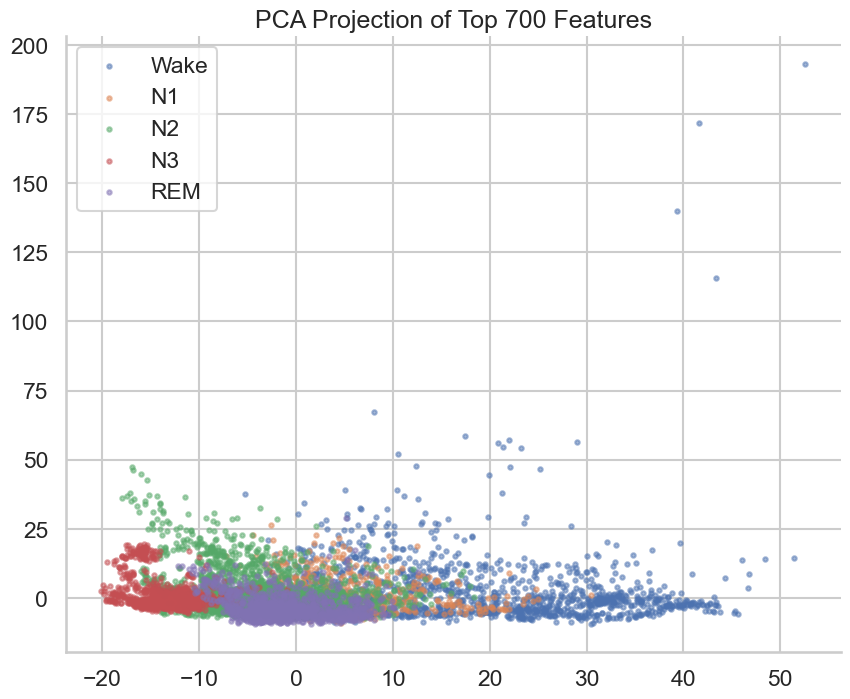

In [17]:
analyze_feature_reduction(X_df_reduced, y)

# --- LABEL INTEGRITY CHECK ---
if y is not None:
    # Print the number of labels (should match X_df.shape[0])
    print("y shape:", y.shape)
    
    # Calculate the Class Balance
    unique, counts = np.unique(y, return_counts=True)
    print("Label distribution:", dict(zip(unique, counts)))
else:
    print("No label returned (y is None). Check _load_target_array and build_dataset keep_labels.")

# --- DATAFRAME PREVIEW ---
X_df.head()


The we do a Feature Alignment, it consists of forcing the Test dataframe to have exactly the same columns, in the exact same order, as the Training dataframe.

for small explaination : 

Why do we do it? Machine Learning models (like XGBoost) are blind to column names after training; they only know that "Feature #42" has a specific weight.

Consistency: Since data processing steps (like dropping correlated features) can behave differently on the Test set (keeping feature_B instead of feature_A), the columns might mismatch.

Prevention: This step ensures the model doesn't crash due to missing columns and doesn't produce nonsense predictions by interpreting the wrong column as a specific feature.

In [18]:
# ============================================================
# 🧪 SIMULATION OF TEST PRE-PROCESSING (LOCAL CLIPPING)
# ============================================================
print("\n" + "="*60)
print("🧪 DATA PREPARATION: TEST SIMULATION (Local Clipping)...")
print("="*60)

X_df_simulated_list = []
y_simulated_list = []
groups_simulated_list = []

# Get the list of unique patients (subjects)
unique_groups = np.unique(groups)
print(f"Processing {len(unique_groups)} patients to simulate the test environment...")

for grp in unique_groups:
    # 1. Isolate the patient (Subject-Specific Processing)
    # We treat each patient as if they were the ONLY one existing, 
    # just like in the inference loop where we receive one file at a time.
    mask = (groups == grp)
    chunk_X = X_df[mask].copy()
    chunk_y = y[mask].copy()
    
    # 2. LOCAL CLIPPING (0.5% - 99.5%) - CRITICAL MATCH FOR TEST
    # Outliers (artifacts) usually skew the data.
    # We clip values to the 0.5th and 99.5th percentiles.
    # KEY POINT: These percentiles are calculated LOCALLY (on this patient only),
    # not globally on the whole dataset. 
    # Why? Because in the test set, we process records one by one and don't know global stats.
    numeric_cols = chunk_X.select_dtypes(include=[np.number]).columns
    low = chunk_X[numeric_cols].quantile(0.005)
    up = chunk_X[numeric_cols].quantile(0.995)
    
    # Apply the clip
    chunk_X[numeric_cols] = chunk_X[numeric_cols].clip(lower=low, upper=up, axis=1)
    
    # Store the processed chunk
    X_df_simulated_list.append(chunk_X)
    y_simulated_list.append(chunk_y)
    groups_simulated_list.extend([grp] * len(chunk_y))

# 3. Reassemble the Full Transformed Dataset
# We concatenate all the locally processed chunks back into one big training matrix.
X_df_final = pd.concat(X_df_simulated_list, axis=0).reset_index(drop=True)
y_final = np.concatenate(y_simulated_list)
groups_final = np.array(groups_simulated_list)

print(f"✅ Data ready for validation. Shape : {X_df_final.shape}")


🧪 DATA PREPARATION: TEST SIMULATION (Local Clipping)...
Processing 8 patients to simulate the test environment...
✅ Data ready for validation. Shape : (7417, 700)


## Step 11 — Define model class

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import numpy as np

class SeededXGBClassifier(BaseEstimator, ClassifierMixin):
    """
    Wrapper class that trains N instances of an XGBoost model with different random seeds
    and averages their predictions (soft voting).
    
    It also implements a 'feature_importances_' property to mimic a standard XGBoost model,
    allowing feature audit scripts to work without modification.
    """
    def __init__(self, base_model, n_seeds=5, base_seed=42):
        """
        Args:
            base_model: The untained XGBoost classifier (with your best hyperparameters).
            n_seeds (int): How many variations to train (e.g., 5).
            base_seed (int): The starting random seed (e.g., 42). 
                             Seeds used will be 42, 43, 44...
        """
        self.base_model = base_model
        self.n_seeds = n_seeds
        self.base_seed = base_seed
        self.models_ = []    # To store the 5 trained models
        self.classes_ = None # To store target classes (Wake, N1...)

    def fit(self, X, y, sample_weight=None):
        """
        Trains the N models sequentially.
        """
        self.models_ = []
        self.classes_ = np.unique(y)
        
        print(f"🌱 Starting Seed Averaging ({self.n_seeds} models)...")
        
        for i in range(self.n_seeds):
            # 1. Create a fresh copy of the base model
            model = clone(self.base_model)
            
            # 2. Change the random seed for this specific iteration
            # This forces XGBoost to build slightly different trees.
            current_seed = self.base_seed + i
            model.set_params(random_state=current_seed)
            
            # 3. Train
            if sample_weight is not None:
                model.fit(X, y, sample_weight=sample_weight)
            else:
                model.fit(X, y)
            
            # 4. Save the trained model
            self.models_.append(model)
            
        print(f"✅ Training finished for all {self.n_seeds} seeds.")
        return self

    def predict(self, X):
        """
        Returns the class labels (Wake, N1...) based on averaged probabilities.
        """
        avg_probs = self.predict_proba(X)
        return self.classes_[np.argmax(avg_probs, axis=1)]

    def predict_proba(self, X):
        """
        THE MAGIC HAPPENS HERE:
        1. Ask each of the 5 models for their probability predictions.
        2. Calculate the average probability across all models.
        """
        # Collect predictions from all models
        all_probs = [model.predict_proba(X) for model in self.models_]
        
        # Mean across the 0-th axis (average over the models)
        return np.mean(all_probs, axis=0)

    @property
    def feature_importances_(self):
        """
        Utility to prevent code crash.
        When you call model.feature_importances_, this calculates the average
        importance of features across the 5 models.
        """
        if not self.models_:
            return None
        return np.mean([m.feature_importances_ for m in self.models_], axis=0)

## Step 11 — Find the hyperparameters of the model

For the compilation, we will use standard parameters found previously

In [20]:
# best_params = get_or_run_tuning(X_df, y, groups)

best_params = {
    "n_estimators": 1500, 
    "learning_rate": 0.013,
    
    "max_depth": 8,          
    "min_child_weight": 5,    
    
    "subsample": 0.66,
    "colsample_bytree": 0.70,
    
    "gamma": 0.1,
    "reg_alpha": 0.25,       
    "reg_lambda": 3.8,
}

## Step 12 — Definition of the models

In order to reduce the standard deviation, we will use 5 XGBoost (defined in the previous class) with differents random seed, and predict using the average of thoses 5 models

In [21]:
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(VALID_LABELS)),
    # --- ACTIVATION GPU ---
    device='cuda',          # <--- Le GPU va prendre le relais
    tree_method='hist',     # <--- Algorithme optimisé GPU
    # ----------------------

    # random_state sera géré par le wrapper
    n_jobs=1,

    eval_metric='mlogloss',
    max_delta_step=1,
    **best_params 
)

# 2. On l'enveloppe dans notre classe Seed Averaging
# Cela devient votre "final_model" pour tout le reste du script
final_model = SeededXGBClassifier(
    base_model=xgb_base, 
    n_seeds=5,              # On entraîne 5 modèles (Seed 42, 43, 44, 45, 46)
    base_seed=RANDOM_STATE
)

## Step 13 — Cross validation 

With lots of tools, we manage to have a MACRO F1 Score on the CV quite close with the kaggle score

Due to lack of time during compilation, we turn RUN_FULL_CV_ANALYSIS to False, please let RUN_FULL_CV_ANALYSIS = True to run the cross validation and its graphical tools


🔧 EXECUTION MODE: 🔬 FULL ANALYSIS (CV)

--- STARTING CROSS-VALIDATION ON SIMULATED DATA ---
⏳ Computing OOF predictions...
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.


c:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\kaggle\.venv_catboost\Lib\site-packages\xgboost\core.py:774: UserWarning: [16:06:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
🌱 Starting Seed Averaging (5 models)...
✅ Training finished for all 5 seeds.
📥 Loading optimal weights from C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\best_class_weights.json...

--- Searching for best N1 threshold ---
Recherche du meilleur seuil en cours...

✅ RÉSULTATS OPTIMISATION
Meilleur Seuil (Threshold) : 0.39
Meilleur F1-Score          : 0.6095
----------------------------------------
🚀 BEST N1 THRESHOLD FOUND: 0.39

📊 PATIENT-LEVEL DETAILS (LOSO ANALYTICS)
Patient 0 : F1 = 0.6343 | Acc = 0.7042

C:\Users\TOUJAN Oceam\AppData\Local\Temp\ipykernel_29396\2403489291.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confusion_dest.index, y=confusion_dest.values, ax=axes[0], palette="Reds_r")
C:\Users\TOUJAN Oceam\AppData\Local\Temp\ipykernel_29396\2403489291.py:237: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confusion_src.index, y=confusion_src.values, ax=axes[1], palette="Blues_r")


📝 Exporting detailed N1 error analysis...
💾 Saved 377 error details to: C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\n1_errors_debug.json
🕵️ Analyzing error patterns for False N1s...
Total False N1 analyzed: 161
🥪 'Sandwich' Errors (Isolated): 34 (21.1%)
➡️ 'Transition' Errors: 103 (64.0%)
💡 CONCLUSION: Your errors are mostly during transitions.
   Smoothing rules will be less effective.


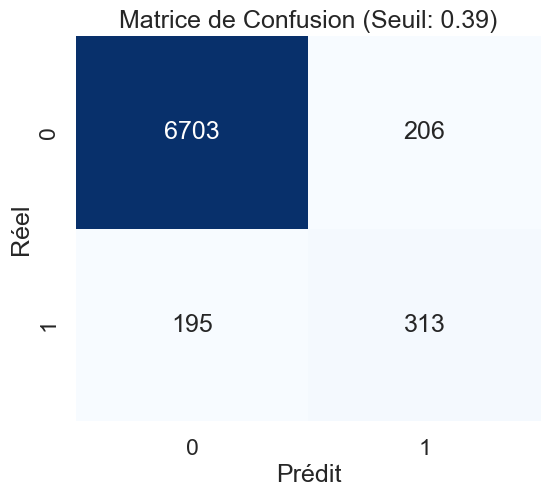

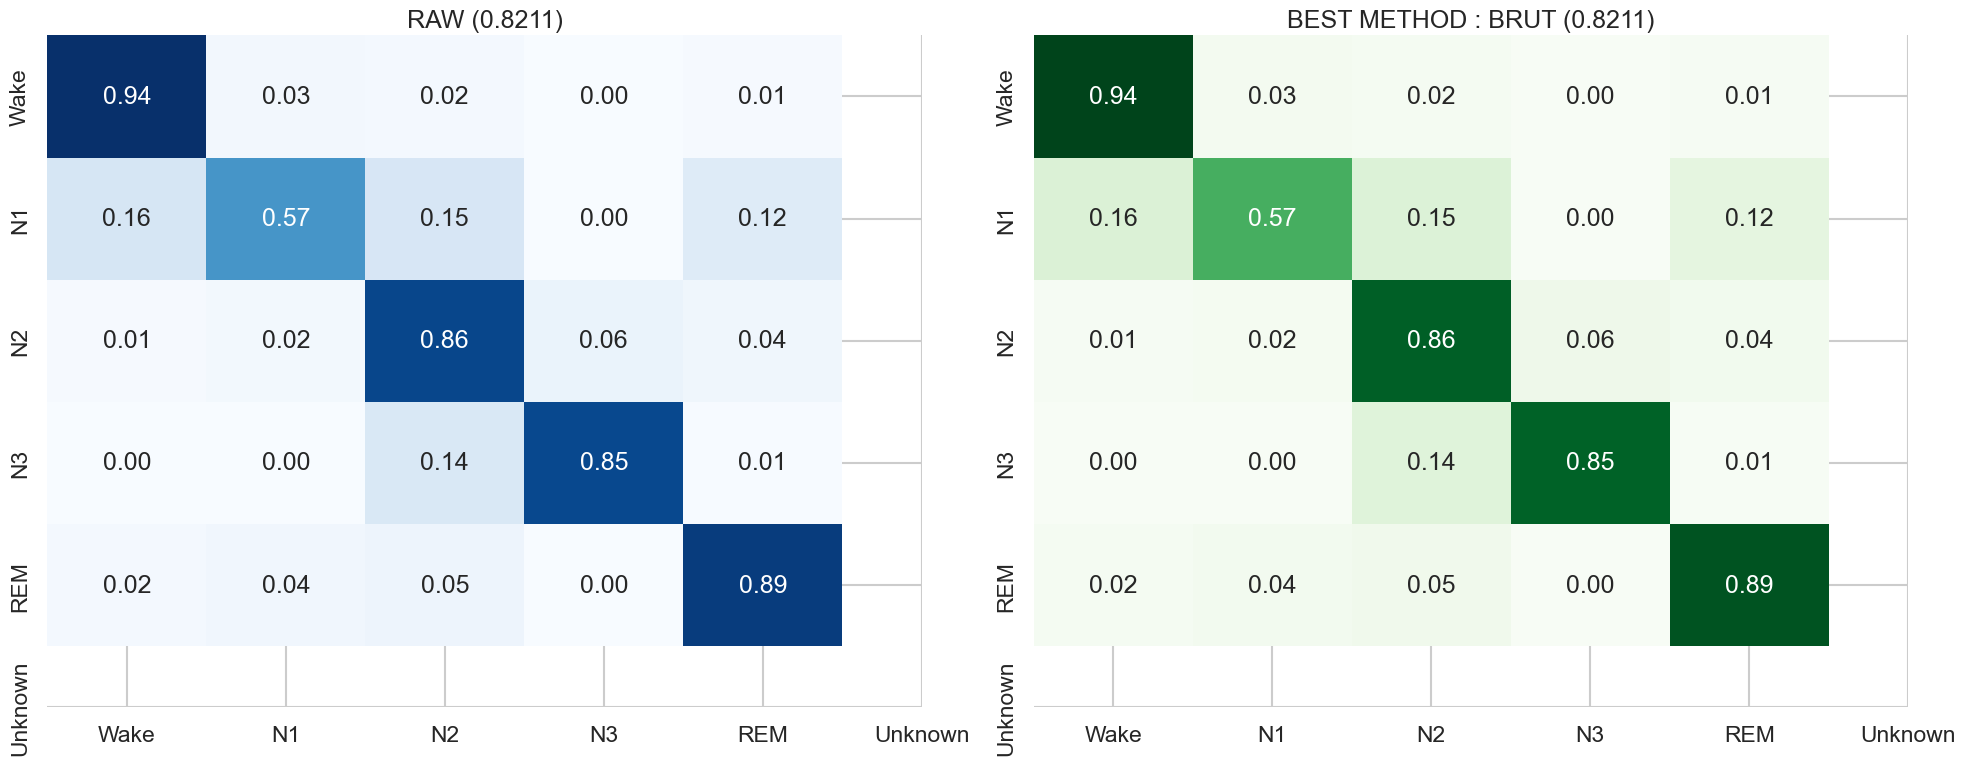

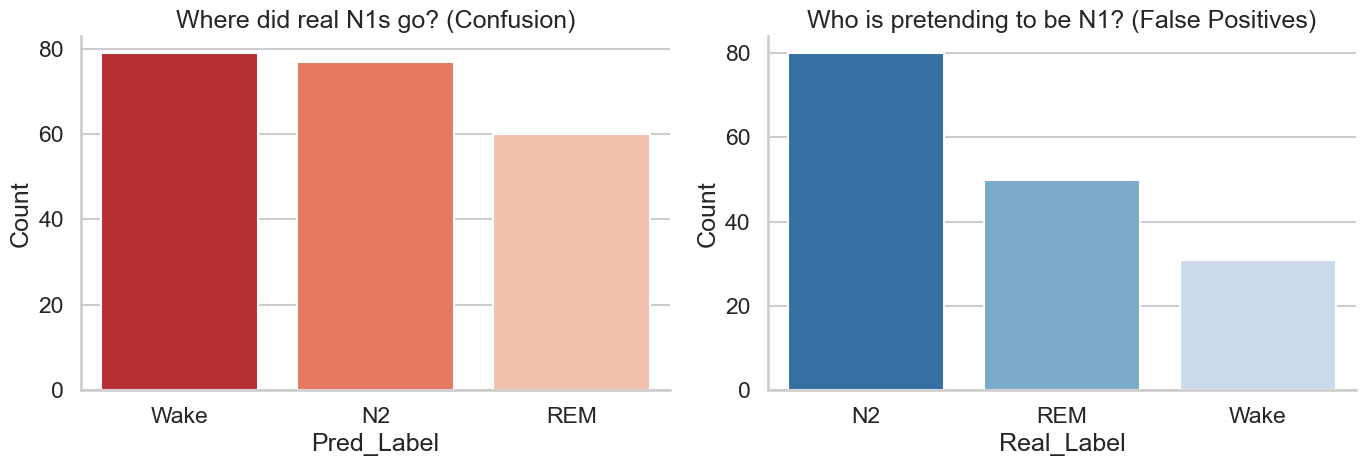

In [24]:
import warnings
from sklearn.pipeline import Pipeline 
# On ignore spécifiquement les UserWarning qui contiennent "use_label_encoder"
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")

# ============================================================
# 🔩 INITIALIZATION
# ============================================================
RUN_FULL_CV_ANALYSIS = True 

print(f"\n🔧 EXECUTION MODE: {'🔬 FULL ANALYSIS (CV)' if RUN_FULL_CV_ANALYSIS else '⏩ FAST FORWARD (Fixed Params)'}")

# Initialize global variables
best_class_weights = None
best_thresh_n1 = 0.5
score_raw = 0.0

# ============================================================
# 🔬 ANALYSIS LAB (CV + SMOOTHING + METRICS)
# ============================================================
WEIGHTS_FILE = BUNDLE_DIR / 'best_class_weights.json'

if RUN_FULL_CV_ANALYSIS:
    print("\n--- STARTING CROSS-VALIDATION ON SIMULATED DATA ---")

    # 1. CV Pipeline
    cv_pipe = Pipeline(steps=[
        ('scaler', RobustScaler()), 
        ('model', final_model) # Using our SeededXGBClassifier wrapper
    ])

    # 2. Out-Of-Fold (OOF) Predictions
    print("⏳ Computing OOF predictions...")
    fit_params = {'model__sample_weight': compute_sample_weight('balanced', y_final)}

    oof_probs = cross_val_predict(
        cv_pipe, X_df_final, y_final, 
        cv=GroupKFold(n_splits=len(np.unique(groups_final))), # One fold per patient (LOSO)
        n_jobs=1, 
        groups=groups_final,
        params=fit_params,
        method='predict_proba'
    )

    # 3. Automatic Weight Optimization
    # We find the perfect multipliers to balance the classes POST-prediction.
    best_class_weights = find_best_class_weights(y_final, oof_probs, WEIGHTS_FILE)

    # 4. N1 Threshold Optimization
    # We specifically tune the sensitivity for N1 (the hardest class).
    print("\n--- Searching for best N1 threshold ---")
    y_final_binary_n1 = (y_final == 1).astype(int)
    best_thresh_n1 = optimize_threshold_and_evaluate(y_final_binary_n1, oof_probs[:, 1])
    print(f"🚀 BEST N1 THRESHOLD FOUND: {best_thresh_n1:.2f}")

    # ============================================================
    # 🔍 DETAILED PATIENT ANALYSIS (LOSO + HYPNOGRAMS)
    # ============================================================
    print("\n" + "="*60)
    print("📊 PATIENT-LEVEL DETAILS (LOSO ANALYTICS)")
    print("="*60)
    
    # Create debug folder for plots
    DEBUG_DIR = BUNDLE_DIR / 'debug_plots_analysis'
    DEBUG_DIR.mkdir(exist_ok=True)
    
    patient_scores = []
    unique_patients = np.unique(groups_final)
    
    # Apply optimal weights to probabilities globally for analysis
    final_probs_weighted = oof_probs * best_class_weights
    final_preds_global = np.argmax(final_probs_weighted, axis=1)

    for pid in unique_patients:
        # Mask for current patient
        mask = (groups_final == pid)
        y_true_p = y_final[mask]
        y_pred_p = final_preds_global[mask] 
        
        f1_p = f1_score(y_true_p, y_pred_p, average='macro')
        acc_p = accuracy_score(y_true_p, y_pred_p)
        patient_scores.append(f1_p)
        
        print(f"Patient {pid} : F1 = {f1_p:.4f} | Acc = {acc_p:.4f}")
        
        # Generate Comparative Hypnogram
        plot_path = DEBUG_DIR / f"hypno_Patient_{pid}_F1_{f1_p:.3f}.png"
        plot_comparative_hypnogram(y_true_p, y_pred_p, 
                                   title=f"Hypnogram Patient {pid} (F1: {f1_p:.3f})", 
                                   save_path=plot_path)

    print("-" * 30)
    print(f"Average LOSO F1 : {np.mean(patient_scores):.4f}")
    print(f"Min F1 : {np.min(patient_scores):.4f} (⚠️ Your 'Patient 0' / Worst Case)")
    print(f"Max F1 : {np.max(patient_scores):.4f}")
    print(f"📸 Hypnograms saved to: {DEBUG_DIR}")

    # ============================================================
    # 4. FINAL REPORT: RAW vs SURGICAL vs SMOOTHING
    # ============================================================
    print("\n" + "="*50)
    print("📊 FINAL COMPARISON: RAW vs SURGERY vs VOTING vs SOFT")
    print("="*50)

    # 1. Raw Score (Baseline)
    score_raw = f1_score(y_final, final_preds_global, average='macro')
    print(f"\n--- 1. RAW RESULTS (Score: {score_raw:.5f}) ---")
    print(classification_report(y_final, final_preds_global, target_names=[STAGE_LABELS[i] for i in VALID_LABELS]))

    # 2. Surgical Correction Test (Hard Rules)
    print("\n--- 2. APPLYING SURGICAL CORRECTION (Conf < 0.70) ---")
    final_preds_surgical = apply_surgical_correction(
        preds=final_preds_global, 
        probs=oof_probs, 
        max_conf_n1=0.70 
    )
    score_surgical = f1_score(y_final, final_preds_surgical, average='macro')

    # 3. Voting Smoothing Test (Window 5)
    print("\n--- 3. APPLYING VOTING SMOOTHING (Majority V30) ---")
    final_preds_smoothed = apply_majority_smoothing(final_preds_global, window_size=5)
    score_smooth = f1_score(y_final, final_preds_smoothed, average='macro')

    # 4. Soft Smoothing Test (Probabilistic)
    print("\n--- 4. APPLYING SOFT SMOOTHING (Probabilistic) ---")
    
    # We smooth the WEIGHTED probabilities directly
    probs_soft_smoothed = smooth_probabilities_rolling(final_probs_weighted, window_size=3)
    
    # Argmax is taken AFTER smoothing
    final_preds_soft = np.argmax(probs_soft_smoothed, axis=1)
    
    score_soft = f1_score(y_final, final_preds_soft, average='macro')
    
# ============================================================
    # --- 5. VITERBI APPLICATION (Sequential Modeling) ---
    # ============================================================
    print("\n--- 5. VITERBI APPLICATION (Sequential HMM Decoding) ---")

    # 1. Estimate Transition Matrix (Physiological Prior)
    trans_matrix_estimated = estimate_transition_matrix(y_final)

    # 2. Apply Algorithm
    # Viterbi finds the most probable sequence of states given:
    final_preds_viterbi = viterbi_decoding(final_probs_weighted, trans_matrix_estimated)

    score_viterbi = f1_score(y_final, final_preds_viterbi, average='macro')

    # Final Comparative Display
    print("-" * 50)
    print(f"🏆 RAW SCORE            : {score_raw:.5f}")
    print(f"💉 SURGICAL SCORE       : {score_surgical:.5f} (Gain: {score_surgical - score_raw:+.5f})")
    print(f"🗳️ VOTING SCORE         : {score_smooth:.5f}   (Gain: {score_smooth - score_raw:+.5f})")
    print(f"🌊 SOFT SCORE           : {score_soft:.5f}     (Gain: {score_soft - score_raw:+.5f})")
    print(f"🔗 VITERBI SCORE        : {score_viterbi:.5f}  (Gain: {score_viterbi - score_raw:+.5f})")
    print("-" * 50)

    # Update Best Method Selection Logic
    # We put all candidates in a dictionary to find the winner dynamically.
    scores_dict = {
        'brut': score_raw,
        'surgical': score_surgical,
        'vote': score_smooth,
        'soft': score_soft,
        'viterbi': score_viterbi
    }

    # Find the Winner
    best_method = max(scores_dict, key=scores_dict.get)

    if best_method == 'viterbi':
        print("✅ Viterbi is the best strategy (Temporal Consistency)!")
        final_preds_best = final_preds_viterbi
    elif best_method == 'soft':
        print("✅ Soft Smoothing is the best strategy!")
        final_preds_best = final_preds_soft
    elif best_method == 'vote':
        print("✅ Voting Smoothing is the best strategy!")
        final_preds_best = final_preds_smoothed
    elif best_method == 'surgical':
        print("✅ Surgical Correction is the best strategy!")
        final_preds_best = final_preds_surgical
    else:
        print("❌ Post-processing ineffective. Keeping RAW predictions.")
        final_preds_best = final_preds_global

    # Matrix Visualization
    # We compare the baseline (Raw) vs the Winner to visually confirm the improvement.
    cm_raw = confusion_matrix(y_final, final_preds_global, normalize='true')
    cm_best = confusion_matrix(y_final, final_preds_best, normalize='true')

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot Raw
    sns.heatmap(cm_raw, annot=True, fmt='.2f', xticklabels=STAGE_LABELS.values(), yticklabels=STAGE_LABELS.values(), cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'RAW ({score_raw:.4f})')

    # Plot Winner
    sns.heatmap(cm_best, annot=True, fmt='.2f', xticklabels=STAGE_LABELS.values(), yticklabels=STAGE_LABELS.values(), cmap='Greens', ax=axes[1], cbar=False)
    axes[1].set_title(f'BEST METHOD : {best_method.upper()} ({scores_dict[best_method]:.4f})')

    plt.tight_layout()
    plt.savefig('confusion_matrix_comparison.png')

    # Final N1 Error Analysis
    # N1 is the hardest class, so we perform a dedicated autopsy on its errors.
    labels_mapping_analysis = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    analyse_erreurs_n1(y_final, final_preds_best, labels_mapping_analysis)

    # Debug Export
    # We save the probabilities and errors to a JSON file to inspect them manually later.
    probs_for_debug = oof_probs * best_class_weights 
    export_n1_error_details(y_final, final_preds_best, probs_for_debug, BUNDLE_DIR / 'n1_errors_debug.json')
    analyze_error_patterns(y_final, final_preds_best)
else:
    # --- FAST FORWARD MODE (PRODUCTION) ---
    print("\n⏩ SKIP CROSS-VALIDATION : Loading Gold Standard Parameters.")
    
    # AUTOMATIC WEIGHT LOADING
    if os.path.exists(WEIGHTS_FILE):
        with open(WEIGHTS_FILE, 'r') as f:
            best_class_weights = np.array(json.load(f))
        print(f"✅ Weights loaded from file : {best_class_weights}")
    else:
        # Fallback weights record kaggle
        best_class_weights = np.array([0.9118, 0.9965, 0.9785, 1.3476, 1.2194])
        print(f"⚠️ Weights file not found, using default : {best_class_weights}")
    # 2. Best Threshold N1 (Forced)
    best_thresh_n1 = 0.42
    print(f"✅ N1 Threshold forced : {best_thresh_n1}")

    # 3. Reference Score for file naming
    score_raw = 0.2222
    
    # Clear RAM
    oof_probs = None
    print("✅ Parameters loaded. Ready for Final Training.")

## Step 14 — Training the final model

As previously, we train the 5 XGBoost, but here with all data 

In [25]:
# Define the path where the "Final Boss" model is stored.
MODEL_OUT = BUNDLE_DIR / 'models' / 'final_xgb_tuned.joblib'

if MODEL_OUT.exists():
    # SCENARIO A: The model file exists.
    print(f"📥 Loading model from: {MODEL_OUT}")
    final_pipe = joblib.load(MODEL_OUT)
    print("✅ Model loaded successfully!")
    
else:
    # SCENARIO B: The model file is missing.
    print("⚠️ Saved model not found. Starting training sequence...")
    
    # 1. Create the Pipeline
    final_pipe = Pipeline(steps=[
        ('scaler', StandardScaler()), # Normalizes features (Mean=0, Std=1)
        ('model', final_model)        # Your SeededXGBClassifier
    ])
    
    # 2. Handle Class Imbalance
    # Sleep data is imbalanced (Lots of N2, very little N1), we estimate 'sample_weights' to tell the modelto focus on N1
    train_weights = compute_sample_weight(class_weight='balanced', y=y)
    
    # 3. Fit the Pipeline
    final_pipe.fit(X_df, y, model__sample_weight=train_weights) 
    
    # 4. Save (Persist)
    joblib.dump(final_pipe, MODEL_OUT)
    print(f"💾 New model saved to: {MODEL_OUT}")

📥 Loading model from: C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\models\final_xgb_tuned.joblib
✅ Model loaded successfully!


save and show features


In [26]:
# ============================================================
# 📊 FEATURE AUDIT (DETAILED IMPORTANCE ANALYSIS)
# ============================================================
print("\n--- ANALYSIS OF KEY FEATURES ---")

# 1. Access the Model inside the Pipeline
xgb_model = final_pipe.named_steps['model']

# 2. Extract Importance Scores
importances = xgb_model.feature_importances_
feature_names = X_df_final.columns

# 3. Create a Readable DataFrame
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# 4. Sort by Impact
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 5. Calculate Cumulative Importance
# This helps answer: "How many features do I need to explain 95% of the model?"
fi_df['cumulative_importance'] = fi_df['importance'].cumsum()

# 6. Display the Top 10
print(fi_df.head(10))

# 7. Save to File
# Essential for reporting. You can open this CSV in Excel later to discuss with experts.
csv_path = BUNDLE_DIR / 'feature_importances_V30_700_features.csv'
fi_df.to_csv(csv_path, index=False)
print(f"💾 Full audit saved to: {csv_path}")


--- ANALYSIS OF KEY FEATURES ---
                                    feature  importance  cumulative_importance
0                ch3_rel_bp_beta_mean_roll5    0.071957               0.071957
56               ch2_rel_bp_beta_mean_roll5    0.042421               0.114378
7    ch4_sigma_max_envelope_mean_macro_mean    0.038024               0.152402
8                      ch2_rel_bp_beta_mean    0.037095               0.189497
4                   ch2_spectral_slope_mean    0.023434               0.212931
104               ch2_rel_bp_beta_mean_lag1    0.021375               0.234306
1         ch4_sigma_max_envelope_mean_roll5    0.020634               0.254940
18              ch1_rel_bp_sigma_mean_roll5    0.016768               0.271709
6                      ch3_rel_bp_beta_mean    0.016435               0.288144
10                  ch3_spectral_slope_mean    0.014699               0.302843
💾 Full audit saved to: C:\Users\TOUJAN Oceam\Documents\CentraleSupelec\3A\cours\ML\Kaggle_final\f

## Step 15 — Prediction on the test set


In [27]:
# ============================================================
# 🚀 FINAL PREDICTION ON TEST SET
# ============================================================
print("\n" + "="*60)
print("🚀 GENERATING SUBMISSION (TEST DATA)")
print("="*60)

# 1. LOAD OPTIMIZED WEIGHTS     (it was usefull to just train final model with different weight set and see result on kaggle)
if os.path.exists(WEIGHTS_FILE):
    with open(WEIGHTS_FILE, 'r') as f:
        CLASS_WEIGHTS = np.array(json.load(f))
    print(f"✅ Optimal weights loaded: {CLASS_WEIGHTS}")
else:
    print(f"⚠️ WARNING: Weights not found, using the standard value best_class_weights : {best_class_weights}.")
    CLASS_WEIGHTS = best_class_weights

# 2. PREPARATION
submission_rows = []
test_record_ids = _discover_record_ids(BUNDLE_DIR, 'test')
total_test = len(test_record_ids)

print(f"Processing {total_test} test records...")

# We iterate through each patient one by one (to manage RAM and mimic real-time scoring)
for i, record_id in enumerate(test_record_ids):
    
    # --- A. Retrieve the Signal ---
    signal_array = None
    # We find the file corresponding to the ID
    for rid, sig in iter_signals_only(BUNDLE_DIR, 'test'):
        if rid == record_id:
            signal_array = sig
            break
            
    if signal_array is None: continue

    print(f"[{i+1}/{total_test}] Record {record_id}...", end="\r")

    # --- B. Feature Engineering (Same as Train) ---
    # 1. Bandpass Filter (0.1 - 40 Hz)
    sig_filt = bandpass_filter(signal_array, fs, lowcut=0.1, highcut=40.0)
    n_epochs = sig_filt.shape[1] // SAMPLES_PER_EPOCH
    
    # 2. Extract Features per Epoch
    feats_list = []
    for e in range(n_epochs): 
        start = e * SAMPLES_PER_EPOCH
        epoch = sig_filt[:, start : start + SAMPLES_PER_EPOCH]
        feats_list.append(extract_epoch_features(epoch, fs))

    # Convert to DataFrame
    X_test_df = pd.DataFrame(feats_list).fillna(0)

    # ============================================================
    # 🧹 CRITICAL CORRECTION: LOCAL CLIPPING (Matches Train Simulation)
    # ============================================================
    # We clip outliers based on THIS patient's specific statistics to prevent a noisy patient from breaking the scale.
    numeric_cols = X_test_df.select_dtypes(include=[np.number]).columns
    low = X_test_df[numeric_cols].quantile(0.005)
    up = X_test_df[numeric_cols].quantile(0.995)
    X_test_df[numeric_cols] = X_test_df[numeric_cols].clip(lower=low, upper=up, axis=1)
    
    # === CRITICAL ADDITION V20/V22 (Time) ===
    # Adding relative time (0.0 to 1.0) and absolute counter.
    n_test_epochs = len(X_test_df)
    X_test_df['relative_time'] = np.arange(n_test_epochs) / n_test_epochs
    X_test_df['absolute_epoch_idx'] = np.arange(n_test_epochs)
    
    # --- C. Context Creation ---
    
    # 1. Rolling Mean (Smoothing features over 5 epochs)
    roll_keywords = ['alpha', 'theta', 'delta', 'sigma', 'beta', 'flatness', 'slope', 'mobility', 'entropy', 'complexity']
    cols_to_roll = [c for c in X_test_df.columns if any(k in c for k in roll_keywords) and 'mean' in c]
    
    X_rolling = X_test_df[cols_to_roll].rolling(window=5, center=True, min_periods=1).mean().add_suffix('_roll5')
    
    # 2. Macro-Context (10 min history)
    X_macro_mean = X_test_df[cols_to_roll].rolling(window=21, center=True, min_periods=1).mean().add_suffix('_macro_mean')
    X_macro_std = X_test_df[cols_to_roll].rolling(window=21, center=True, min_periods=1).std().add_suffix('_macro_std')
    X_macro_std = X_macro_std.fillna(0)

    # 3. Lag / Lead (Previous and Next epoch info)
    X_lag = X_test_df.shift(1).add_suffix('_lag1')
    X_lead = X_test_df.shift(-1).add_suffix('_lead1')
    
    # ============================================================
    # 🚀 MISSING ADDITION V22 (TEST): Alpha Drop & Composite
    # ============================================================
    
    X_alpha_drop_test = pd.DataFrame(index=X_test_df.index)
    X_composite_test = pd.DataFrame(index=X_test_df.index)

    # Calculate Alpha Drop
    for ch in range(5):
         col_alpha = f'ch{ch}_rel_bp_alpha_mean'
         if col_alpha in X_test_df.columns:
             X_alpha_drop_test[f'ch{ch}_alpha_drop'] = X_test_df[col_alpha] / (X_test_df[col_alpha].shift(1) + 1e-6)

    # Calculate Composite Marker (Deep Sleep / Light Sleep ratio)
    col_beta = 'ch2_rel_bp_beta_mean'
    col_delta = 'ch2_rel_bp_delta_mean'
    col_alpha = 'ch2_rel_bp_alpha_mean'
    
    if all(c in X_test_df.columns for c in [col_beta, col_delta, col_alpha]):
        val = (X_test_df[col_delta] * X_test_df[col_alpha]) / (X_test_df[col_beta] + 1e-6)
        X_composite_test['composite_n1_marker'] = val
    else:
        X_composite_test['composite_n1_marker'] = 0.0

    # 4. Final Assembly
    X_test_final = pd.concat([
        X_test_df, 
        X_lag, 
        X_lead, 
        X_rolling, 
        X_macro_mean, 
        X_macro_std,
        X_alpha_drop_test,  
        X_composite_test     
    ], axis=1)
    
    X_test_final = X_test_final.fillna(0) # to ensure we have the right dimension for the submission
    
    
    try:
        X_test_reduced = X_test_final[SELECTED_FEATURES]        
    except KeyError as e:
        missing = list(set(SELECTED_FEATURES) - set(X_test_final.columns))
        for c in missing: X_test_final[c] = 0
        X_test_reduced = X_test_final[SELECTED_FEATURES]

    # --- D. PREDICTION ---
    
    # 1. Raw Probabilities
    probs_raw = final_pipe.predict_proba(X_test_reduced)
    
    # 2. Apply Optimized Weights
    probs_weighted = probs_raw * CLASS_WEIGHTS
    
    # 3. Final Decision (Argmax)
    final_preds = np.argmax(probs_weighted, axis=1)
        
    # SMOOTHING ADDITION
    print("🌊 Applying majority smoothing...")
    final_preds = final_preds # apply_majority_smoothing(final_preds, window_size=5)  because we saw that 
                              # the model was stronger than every smoothing 

    # --- E. Storage ---
    # We prepare the rows for the submission CSV.
    for ep in range(n_epochs):
        submission_rows.append({
            'identifier': record_id * 10000 + ep,
            'target': final_preds[ep]
        })


🚀 GENERATING SUBMISSION (TEST DATA)
✅ Optimal weights loaded: [1.03447129 0.92708562 0.98709315 1.44168978 1.06559085]
Processing 4 test records...
🌊 Applying majority smoothing...
🌊 Applying majority smoothing...
🌊 Applying majority smoothing...
🌊 Applying majority smoothing...


## Step 10 — Evaluate on the Validation Split

Accuracy is easy to read, while macro F1 tells us how well the model balances rare stages.


In [28]:
print("Script ending.")

# Sauvegarde
sub_df = pd.DataFrame(submission_rows)
sub_df = sub_df.sort_values(by='identifier').reset_index(drop=True)
sub_file = f"submission_Kaggle_{score_raw:.4f}_700_features.csv"
sub_df.to_csv(sub_file, index=False)
print(f"📄 Saved to csv ! : {sub_file}")

Script ending.
📄 Saved to csv ! : submission_Kaggle_0.8211_700_features.csv
